### In Conditional GANS (CGAN), a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information. This prevents mode-collapse, a common issue with traditional GANS.

### A good example is the MNIST digits dataset. A regular GAN genertor might have success fooling the discriminator with a number 8, so it will likely suffer mode collapse as it will keep trying reproduce that same number, instead of having a variance in the distribution of generated numbers. A CGAN will solve this due to the class labeling that is applied. 

## Step 1: Importing the packages

In [1]:
#installing older vrsion of pillow as latest version breaks PyTorch
##conda install pillow=6.2.1

In [2]:
from __future__ import print_function
#%matplotlib inline

#library which integrates code with operating system
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# used to generate random vector of data/noise as input for the generator
import random 

# helps us write user-frindly code, especially when dealing with varaibles within functions
import argparse 

import math

#main PyTorch framework and libraries we need to use
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim import RMSprop


 #used for most of our mathematical oprations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image


C:\Users\Ray\Anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Getting data and defining hyperparameters

In [3]:
# Root directory for dataset
dataroot = r"C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_images\Crest_Clusters"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 50

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of classes in the training set.
n_classes = 22

# The interval between image sampling.
sample_interval = 400

## Step 3: Loading and plotting our intial data

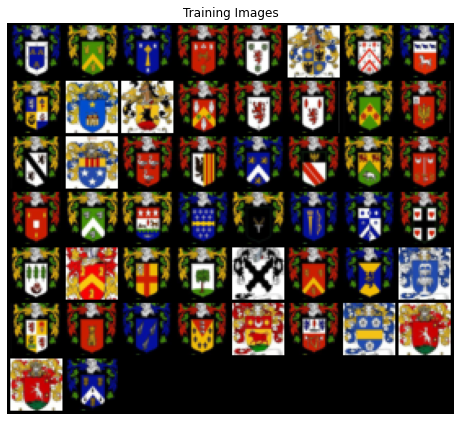

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,# the folder where the data is located
                           #reshaping the data in the form we desire
                           transform=transforms.Compose([
                               transforms.Resize(image_size),#resizing
                               transforms.CenterCrop(image_size), #cropping and centering
                               transforms.ToTensor(), #tranforming image data to tensors
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalising the data
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True, #shuffing images so the  genrator doesn't overfit on the sequence
                                         num_workers=workers)

# Decide which device we want to run on. Basically telling the model to run on the GPU if its available.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device = torch.device("cpu")

# Plot some random training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Step 4: Initialising our weights


In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Step 5: Creating Generator and Discriminator


In [6]:
image_shape = (nc, image_size, image_size)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(nz + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *image_shape)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [8]:
# Create the generators
netG = Generator().to(device)

# Initialize weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(22, 22)
  (model): Sequential(
    (0): Linear(in_features=122, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=3072, bias=True)
    (12): Tanh()
  )
)


In [9]:
# Create the discriminators
netD = Discriminator().to(device)

# Initialize weights
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (label_embedding): Embedding(22, 22)
  (model): Sequential(
    (0): Linear(in_features=3094, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [10]:
# Initialize MSELoss function
loss = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
FloatTensor = torch.cuda.FloatTensor 
LongTensor = torch.cuda.LongTensor

os.makedirs("Crest_Generated_Images_Clustered", exist_ok=True)
os.makedirs(dataroot, exist_ok=True)

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, nz))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = netG(z, labels)
    save_image(gen_imgs.data, "Crest_Generated_Images_Clustered/%d.png" % batches_done, nrow=n_row, normalize=True)

## Step 6: Creating Generator and Discriminator


In [12]:
# ----------
#  Training
# ----------

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, nz))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = netG(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = netD(gen_imgs, gen_labels)
        g_loss = loss(validity, valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Loss for real images
        validity_real = netD(real_imgs, labels)
        d_real_loss = loss(validity_real, valid)

        # Loss for fake images
        validity_fake = netD(gen_imgs.detach(), gen_labels)
        d_fake_loss = loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizerD.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

[Epoch 0/500] [Batch 0/28] [D loss: 0.496961] [G loss: 1.018253]
[Epoch 0/500] [Batch 1/28] [D loss: 0.277812] [G loss: 0.992641]
[Epoch 0/500] [Batch 2/28] [D loss: 0.128145] [G loss: 0.956181]
[Epoch 0/500] [Batch 3/28] [D loss: 0.102544] [G loss: 0.926275]
[Epoch 0/500] [Batch 4/28] [D loss: 0.062207] [G loss: 0.908802]
[Epoch 0/500] [Batch 5/28] [D loss: 0.036140] [G loss: 0.873224]
[Epoch 0/500] [Batch 6/28] [D loss: 0.025414] [G loss: 0.850831]
[Epoch 0/500] [Batch 7/28] [D loss: 0.043384] [G loss: 0.828664]
[Epoch 0/500] [Batch 8/28] [D loss: 0.019368] [G loss: 0.816031]
[Epoch 0/500] [Batch 9/28] [D loss: 0.018450] [G loss: 0.807839]
[Epoch 0/500] [Batch 10/28] [D loss: 0.019967] [G loss: 0.779373]
[Epoch 0/500] [Batch 11/28] [D loss: 0.020739] [G loss: 0.763128]
[Epoch 0/500] [Batch 12/28] [D loss: 0.021022] [G loss: 0.746524]
[Epoch 0/500] [Batch 13/28] [D loss: 0.024190] [G loss: 0.713708]
[Epoch 0/500] [Batch 14/28] [D loss: 0.027369] [G loss: 0.709996]
[Epoch 0/500] [Batch

[Epoch 4/500] [Batch 15/28] [D loss: 0.023827] [G loss: 0.847509]
[Epoch 4/500] [Batch 16/28] [D loss: 0.034041] [G loss: 0.713685]
[Epoch 4/500] [Batch 17/28] [D loss: 0.056870] [G loss: 1.385465]
[Epoch 4/500] [Batch 18/28] [D loss: 0.204519] [G loss: 0.349879]
[Epoch 4/500] [Batch 19/28] [D loss: 0.173630] [G loss: 2.100523]
[Epoch 4/500] [Batch 20/28] [D loss: 0.086758] [G loss: 1.054078]
[Epoch 4/500] [Batch 21/28] [D loss: 0.072234] [G loss: 0.710438]
[Epoch 4/500] [Batch 22/28] [D loss: 0.054093] [G loss: 0.729598]
[Epoch 4/500] [Batch 23/28] [D loss: 0.060816] [G loss: 0.782655]
[Epoch 4/500] [Batch 24/28] [D loss: 0.038904] [G loss: 0.722286]
[Epoch 4/500] [Batch 25/28] [D loss: 0.047757] [G loss: 1.097501]
[Epoch 4/500] [Batch 26/28] [D loss: 0.046400] [G loss: 0.847610]
[Epoch 4/500] [Batch 27/28] [D loss: 0.039126] [G loss: 0.638039]
[Epoch 5/500] [Batch 0/28] [D loss: 0.059136] [G loss: 1.044176]
[Epoch 5/500] [Batch 1/28] [D loss: 0.041625] [G loss: 0.813495]
[Epoch 5/500

[Epoch 9/500] [Batch 0/28] [D loss: 0.032154] [G loss: 0.982966]
[Epoch 9/500] [Batch 1/28] [D loss: 0.034106] [G loss: 0.732753]
[Epoch 9/500] [Batch 2/28] [D loss: 0.019022] [G loss: 1.020591]
[Epoch 9/500] [Batch 3/28] [D loss: 0.032728] [G loss: 0.935229]
[Epoch 9/500] [Batch 4/28] [D loss: 0.070348] [G loss: 0.554997]
[Epoch 9/500] [Batch 5/28] [D loss: 0.096012] [G loss: 1.484802]
[Epoch 9/500] [Batch 6/28] [D loss: 0.032146] [G loss: 1.020078]
[Epoch 9/500] [Batch 7/28] [D loss: 0.052721] [G loss: 0.704737]
[Epoch 9/500] [Batch 8/28] [D loss: 0.036487] [G loss: 0.762940]
[Epoch 9/500] [Batch 9/28] [D loss: 0.025192] [G loss: 0.841663]
[Epoch 9/500] [Batch 10/28] [D loss: 0.020565] [G loss: 1.001264]
[Epoch 9/500] [Batch 11/28] [D loss: 0.020856] [G loss: 0.891370]
[Epoch 9/500] [Batch 12/28] [D loss: 0.017427] [G loss: 0.786606]
[Epoch 9/500] [Batch 13/28] [D loss: 0.026881] [G loss: 0.972683]
[Epoch 9/500] [Batch 14/28] [D loss: 0.026099] [G loss: 0.879853]
[Epoch 9/500] [Batch

[Epoch 13/500] [Batch 14/28] [D loss: 0.026854] [G loss: 0.915961]
[Epoch 13/500] [Batch 15/28] [D loss: 0.014086] [G loss: 0.995763]
[Epoch 13/500] [Batch 16/28] [D loss: 0.017195] [G loss: 0.968777]
[Epoch 13/500] [Batch 17/28] [D loss: 0.018609] [G loss: 0.806315]
[Epoch 13/500] [Batch 18/28] [D loss: 0.012229] [G loss: 0.975696]
[Epoch 13/500] [Batch 19/28] [D loss: 0.021096] [G loss: 0.920798]
[Epoch 13/500] [Batch 20/28] [D loss: 0.023106] [G loss: 0.845276]
[Epoch 13/500] [Batch 21/28] [D loss: 0.021705] [G loss: 0.977832]
[Epoch 13/500] [Batch 22/28] [D loss: 0.021245] [G loss: 0.818684]
[Epoch 13/500] [Batch 23/28] [D loss: 0.019076] [G loss: 0.936029]
[Epoch 13/500] [Batch 24/28] [D loss: 0.017684] [G loss: 0.886585]
[Epoch 13/500] [Batch 25/28] [D loss: 0.036652] [G loss: 0.974883]
[Epoch 13/500] [Batch 26/28] [D loss: 0.016689] [G loss: 0.894450]
[Epoch 13/500] [Batch 27/28] [D loss: 0.026731] [G loss: 1.053867]
[Epoch 14/500] [Batch 0/28] [D loss: 0.032193] [G loss: 0.7573

[Epoch 17/500] [Batch 26/28] [D loss: 0.025061] [G loss: 1.055436]
[Epoch 17/500] [Batch 27/28] [D loss: 0.021693] [G loss: 0.904492]
[Epoch 18/500] [Batch 0/28] [D loss: 0.026618] [G loss: 0.824024]
[Epoch 18/500] [Batch 1/28] [D loss: 0.019883] [G loss: 0.894456]
[Epoch 18/500] [Batch 2/28] [D loss: 0.021367] [G loss: 0.968366]
[Epoch 18/500] [Batch 3/28] [D loss: 0.019013] [G loss: 0.902911]
[Epoch 18/500] [Batch 4/28] [D loss: 0.011555] [G loss: 0.912946]
[Epoch 18/500] [Batch 5/28] [D loss: 0.015655] [G loss: 0.871825]
[Epoch 18/500] [Batch 6/28] [D loss: 0.021277] [G loss: 0.968031]
[Epoch 18/500] [Batch 7/28] [D loss: 0.017312] [G loss: 0.860278]
[Epoch 18/500] [Batch 8/28] [D loss: 0.022082] [G loss: 0.904875]
[Epoch 18/500] [Batch 9/28] [D loss: 0.015855] [G loss: 0.967137]
[Epoch 18/500] [Batch 10/28] [D loss: 0.012731] [G loss: 0.928946]
[Epoch 18/500] [Batch 11/28] [D loss: 0.021293] [G loss: 0.820843]
[Epoch 18/500] [Batch 12/28] [D loss: 0.021287] [G loss: 0.956376]
[Epoc

[Epoch 22/500] [Batch 12/28] [D loss: 0.053965] [G loss: 0.940322]
[Epoch 22/500] [Batch 13/28] [D loss: 0.048251] [G loss: 0.834896]
[Epoch 22/500] [Batch 14/28] [D loss: 0.059772] [G loss: 0.608380]
[Epoch 22/500] [Batch 15/28] [D loss: 0.055398] [G loss: 0.773885]
[Epoch 22/500] [Batch 16/28] [D loss: 0.077446] [G loss: 0.707740]
[Epoch 22/500] [Batch 17/28] [D loss: 0.081026] [G loss: 0.683707]
[Epoch 22/500] [Batch 18/28] [D loss: 0.087713] [G loss: 0.577141]
[Epoch 22/500] [Batch 19/28] [D loss: 0.094882] [G loss: 0.870913]
[Epoch 22/500] [Batch 20/28] [D loss: 0.150655] [G loss: 0.478368]
[Epoch 22/500] [Batch 21/28] [D loss: 0.177575] [G loss: 0.828041]
[Epoch 22/500] [Batch 22/28] [D loss: 0.150022] [G loss: 0.889388]
[Epoch 22/500] [Batch 23/28] [D loss: 0.119683] [G loss: 0.626966]
[Epoch 22/500] [Batch 24/28] [D loss: 0.085260] [G loss: 0.661896]
[Epoch 22/500] [Batch 25/28] [D loss: 0.077551] [G loss: 0.722241]
[Epoch 22/500] [Batch 26/28] [D loss: 0.069708] [G loss: 0.678

[Epoch 26/500] [Batch 25/28] [D loss: 0.071207] [G loss: 0.558058]
[Epoch 26/500] [Batch 26/28] [D loss: 0.110039] [G loss: 1.019613]
[Epoch 26/500] [Batch 27/28] [D loss: 0.319209] [G loss: 0.438298]
[Epoch 27/500] [Batch 0/28] [D loss: 0.366390] [G loss: 0.916363]
[Epoch 27/500] [Batch 1/28] [D loss: 0.213242] [G loss: 1.203260]
[Epoch 27/500] [Batch 2/28] [D loss: 0.152370] [G loss: 0.812649]
[Epoch 27/500] [Batch 3/28] [D loss: 0.134313] [G loss: 0.529663]
[Epoch 27/500] [Batch 4/28] [D loss: 0.123148] [G loss: 0.611626]
[Epoch 27/500] [Batch 5/28] [D loss: 0.076472] [G loss: 0.646760]
[Epoch 27/500] [Batch 6/28] [D loss: 0.063193] [G loss: 0.678593]
[Epoch 27/500] [Batch 7/28] [D loss: 0.053116] [G loss: 0.752643]
[Epoch 27/500] [Batch 8/28] [D loss: 0.042911] [G loss: 0.836231]
[Epoch 27/500] [Batch 9/28] [D loss: 0.059391] [G loss: 0.834270]
[Epoch 27/500] [Batch 10/28] [D loss: 0.056054] [G loss: 0.650767]
[Epoch 27/500] [Batch 11/28] [D loss: 0.068364] [G loss: 0.930875]
[Epoc

[Epoch 31/500] [Batch 8/28] [D loss: 0.065537] [G loss: 0.762750]
[Epoch 31/500] [Batch 9/28] [D loss: 0.054287] [G loss: 0.646141]
[Epoch 31/500] [Batch 10/28] [D loss: 0.074509] [G loss: 0.747764]
[Epoch 31/500] [Batch 11/28] [D loss: 0.062962] [G loss: 0.700934]
[Epoch 31/500] [Batch 12/28] [D loss: 0.091150] [G loss: 1.063902]
[Epoch 31/500] [Batch 13/28] [D loss: 0.148425] [G loss: 0.456370]
[Epoch 31/500] [Batch 14/28] [D loss: 0.202861] [G loss: 1.263626]
[Epoch 31/500] [Batch 15/28] [D loss: 0.073220] [G loss: 0.788405]
[Epoch 31/500] [Batch 16/28] [D loss: 0.100739] [G loss: 0.655787]
[Epoch 31/500] [Batch 17/28] [D loss: 0.066274] [G loss: 0.644900]
[Epoch 31/500] [Batch 18/28] [D loss: 0.069554] [G loss: 0.652939]
[Epoch 31/500] [Batch 19/28] [D loss: 0.047606] [G loss: 0.815781]
[Epoch 31/500] [Batch 20/28] [D loss: 0.043279] [G loss: 0.863331]
[Epoch 31/500] [Batch 21/28] [D loss: 0.046513] [G loss: 0.784755]
[Epoch 31/500] [Batch 22/28] [D loss: 0.037525] [G loss: 0.84670

[Epoch 35/500] [Batch 19/28] [D loss: 0.062250] [G loss: 0.698631]
[Epoch 35/500] [Batch 20/28] [D loss: 0.055915] [G loss: 0.822083]
[Epoch 35/500] [Batch 21/28] [D loss: 0.061931] [G loss: 0.682565]
[Epoch 35/500] [Batch 22/28] [D loss: 0.136633] [G loss: 1.212767]
[Epoch 35/500] [Batch 23/28] [D loss: 0.192827] [G loss: 0.340431]
[Epoch 35/500] [Batch 24/28] [D loss: 0.159493] [G loss: 0.905464]
[Epoch 35/500] [Batch 25/28] [D loss: 0.074027] [G loss: 0.857809]
[Epoch 35/500] [Batch 26/28] [D loss: 0.105675] [G loss: 0.669200]
[Epoch 35/500] [Batch 27/28] [D loss: 0.039823] [G loss: 0.880615]
[Epoch 36/500] [Batch 0/28] [D loss: 0.048153] [G loss: 0.894116]
[Epoch 36/500] [Batch 1/28] [D loss: 0.035189] [G loss: 0.749088]
[Epoch 36/500] [Batch 2/28] [D loss: 0.037897] [G loss: 0.754937]
[Epoch 36/500] [Batch 3/28] [D loss: 0.036069] [G loss: 0.857408]
[Epoch 36/500] [Batch 4/28] [D loss: 0.036433] [G loss: 0.821701]
[Epoch 36/500] [Batch 5/28] [D loss: 0.028589] [G loss: 0.905825]
[

[Epoch 40/500] [Batch 3/28] [D loss: 0.045800] [G loss: 0.852903]
[Epoch 40/500] [Batch 4/28] [D loss: 0.047605] [G loss: 0.880786]
[Epoch 40/500] [Batch 5/28] [D loss: 0.060102] [G loss: 0.698329]
[Epoch 40/500] [Batch 6/28] [D loss: 0.064163] [G loss: 0.959696]
[Epoch 40/500] [Batch 7/28] [D loss: 0.052021] [G loss: 0.758522]
[Epoch 40/500] [Batch 8/28] [D loss: 0.042859] [G loss: 0.773360]
[Epoch 40/500] [Batch 9/28] [D loss: 0.069123] [G loss: 0.894418]
[Epoch 40/500] [Batch 10/28] [D loss: 0.029506] [G loss: 0.848988]
[Epoch 40/500] [Batch 11/28] [D loss: 0.042624] [G loss: 0.854254]
[Epoch 40/500] [Batch 12/28] [D loss: 0.046200] [G loss: 0.805172]
[Epoch 40/500] [Batch 13/28] [D loss: 0.039158] [G loss: 0.890876]
[Epoch 40/500] [Batch 14/28] [D loss: 0.100624] [G loss: 0.580588]
[Epoch 40/500] [Batch 15/28] [D loss: 0.092835] [G loss: 1.088928]
[Epoch 40/500] [Batch 16/28] [D loss: 0.068165] [G loss: 0.669716]
[Epoch 40/500] [Batch 17/28] [D loss: 0.044415] [G loss: 0.813281]
[E

[Epoch 44/500] [Batch 14/28] [D loss: 0.035002] [G loss: 0.884449]
[Epoch 44/500] [Batch 15/28] [D loss: 0.062583] [G loss: 0.693063]
[Epoch 44/500] [Batch 16/28] [D loss: 0.053885] [G loss: 1.009214]
[Epoch 44/500] [Batch 17/28] [D loss: 0.029196] [G loss: 0.857089]
[Epoch 44/500] [Batch 18/28] [D loss: 0.049155] [G loss: 0.716178]
[Epoch 44/500] [Batch 19/28] [D loss: 0.032524] [G loss: 0.865990]
[Epoch 44/500] [Batch 20/28] [D loss: 0.057735] [G loss: 0.838364]
[Epoch 44/500] [Batch 21/28] [D loss: 0.030778] [G loss: 0.834753]
[Epoch 44/500] [Batch 22/28] [D loss: 0.039901] [G loss: 0.876494]
[Epoch 44/500] [Batch 23/28] [D loss: 0.033651] [G loss: 0.799046]
[Epoch 44/500] [Batch 24/28] [D loss: 0.048700] [G loss: 0.796371]
[Epoch 44/500] [Batch 25/28] [D loss: 0.048135] [G loss: 0.825627]
[Epoch 44/500] [Batch 26/28] [D loss: 0.029455] [G loss: 0.927388]
[Epoch 44/500] [Batch 27/28] [D loss: 0.045139] [G loss: 0.830370]
[Epoch 45/500] [Batch 0/28] [D loss: 0.040892] [G loss: 0.8054

[Epoch 48/500] [Batch 25/28] [D loss: 0.050613] [G loss: 0.900151]
[Epoch 48/500] [Batch 26/28] [D loss: 0.095758] [G loss: 0.612104]
[Epoch 48/500] [Batch 27/28] [D loss: 0.112933] [G loss: 1.112521]
[Epoch 49/500] [Batch 0/28] [D loss: 0.120935] [G loss: 0.609890]
[Epoch 49/500] [Batch 1/28] [D loss: 0.070239] [G loss: 0.767632]
[Epoch 49/500] [Batch 2/28] [D loss: 0.061645] [G loss: 0.873818]
[Epoch 49/500] [Batch 3/28] [D loss: 0.050465] [G loss: 0.815173]
[Epoch 49/500] [Batch 4/28] [D loss: 0.037406] [G loss: 0.876131]
[Epoch 49/500] [Batch 5/28] [D loss: 0.041307] [G loss: 0.826738]
[Epoch 49/500] [Batch 6/28] [D loss: 0.037138] [G loss: 0.830599]
[Epoch 49/500] [Batch 7/28] [D loss: 0.036052] [G loss: 0.879297]
[Epoch 49/500] [Batch 8/28] [D loss: 0.034241] [G loss: 0.863610]
[Epoch 49/500] [Batch 9/28] [D loss: 0.054289] [G loss: 0.707053]
[Epoch 49/500] [Batch 10/28] [D loss: 0.043534] [G loss: 0.972289]
[Epoch 49/500] [Batch 11/28] [D loss: 0.062981] [G loss: 0.798270]
[Epoc

[Epoch 53/500] [Batch 8/28] [D loss: 0.042209] [G loss: 0.755319]
[Epoch 53/500] [Batch 9/28] [D loss: 0.057721] [G loss: 0.991290]
[Epoch 53/500] [Batch 10/28] [D loss: 0.078310] [G loss: 0.661999]
[Epoch 53/500] [Batch 11/28] [D loss: 0.107397] [G loss: 1.093283]
[Epoch 53/500] [Batch 12/28] [D loss: 0.055206] [G loss: 0.761984]
[Epoch 53/500] [Batch 13/28] [D loss: 0.044418] [G loss: 0.766457]
[Epoch 53/500] [Batch 14/28] [D loss: 0.036998] [G loss: 0.950516]
[Epoch 53/500] [Batch 15/28] [D loss: 0.047729] [G loss: 0.811645]
[Epoch 53/500] [Batch 16/28] [D loss: 0.047942] [G loss: 0.763087]
[Epoch 53/500] [Batch 17/28] [D loss: 0.023332] [G loss: 0.951261]
[Epoch 53/500] [Batch 18/28] [D loss: 0.037001] [G loss: 0.833200]
[Epoch 53/500] [Batch 19/28] [D loss: 0.037784] [G loss: 0.948991]
[Epoch 53/500] [Batch 20/28] [D loss: 0.048114] [G loss: 0.763100]
[Epoch 53/500] [Batch 21/28] [D loss: 0.047682] [G loss: 0.925791]
[Epoch 53/500] [Batch 22/28] [D loss: 0.045884] [G loss: 0.75098

[Epoch 57/500] [Batch 22/28] [D loss: 0.056609] [G loss: 0.866343]
[Epoch 57/500] [Batch 23/28] [D loss: 0.049274] [G loss: 0.811053]
[Epoch 57/500] [Batch 24/28] [D loss: 0.044684] [G loss: 0.855295]
[Epoch 57/500] [Batch 25/28] [D loss: 0.053248] [G loss: 0.863305]
[Epoch 57/500] [Batch 26/28] [D loss: 0.061426] [G loss: 0.751546]
[Epoch 57/500] [Batch 27/28] [D loss: 0.060006] [G loss: 0.827573]
[Epoch 58/500] [Batch 0/28] [D loss: 0.074081] [G loss: 0.872575]
[Epoch 58/500] [Batch 1/28] [D loss: 0.059282] [G loss: 0.925947]
[Epoch 58/500] [Batch 2/28] [D loss: 0.046820] [G loss: 0.734461]
[Epoch 58/500] [Batch 3/28] [D loss: 0.056272] [G loss: 0.797766]
[Epoch 58/500] [Batch 4/28] [D loss: 0.044032] [G loss: 0.924409]
[Epoch 58/500] [Batch 5/28] [D loss: 0.105891] [G loss: 0.690046]
[Epoch 58/500] [Batch 6/28] [D loss: 0.088286] [G loss: 0.955684]
[Epoch 58/500] [Batch 7/28] [D loss: 0.054683] [G loss: 0.908474]
[Epoch 58/500] [Batch 8/28] [D loss: 0.054731] [G loss: 0.799773]
[Epo

[Epoch 62/500] [Batch 7/28] [D loss: 0.050144] [G loss: 0.813172]
[Epoch 62/500] [Batch 8/28] [D loss: 0.041087] [G loss: 0.818565]
[Epoch 62/500] [Batch 9/28] [D loss: 0.062800] [G loss: 0.781409]
[Epoch 62/500] [Batch 10/28] [D loss: 0.057543] [G loss: 0.843535]
[Epoch 62/500] [Batch 11/28] [D loss: 0.035440] [G loss: 0.794648]
[Epoch 62/500] [Batch 12/28] [D loss: 0.033044] [G loss: 0.869675]
[Epoch 62/500] [Batch 13/28] [D loss: 0.034513] [G loss: 0.956668]
[Epoch 62/500] [Batch 14/28] [D loss: 0.074912] [G loss: 0.784457]
[Epoch 62/500] [Batch 15/28] [D loss: 0.081452] [G loss: 0.966251]
[Epoch 62/500] [Batch 16/28] [D loss: 0.067686] [G loss: 0.765285]
[Epoch 62/500] [Batch 17/28] [D loss: 0.068387] [G loss: 0.786709]
[Epoch 62/500] [Batch 18/28] [D loss: 0.071082] [G loss: 0.819090]
[Epoch 62/500] [Batch 19/28] [D loss: 0.052474] [G loss: 0.875083]
[Epoch 62/500] [Batch 20/28] [D loss: 0.025814] [G loss: 0.990320]
[Epoch 62/500] [Batch 21/28] [D loss: 0.057122] [G loss: 0.741514

[Epoch 66/500] [Batch 18/28] [D loss: 0.038960] [G loss: 0.867951]
[Epoch 66/500] [Batch 19/28] [D loss: 0.043680] [G loss: 0.785173]
[Epoch 66/500] [Batch 20/28] [D loss: 0.035600] [G loss: 0.885008]
[Epoch 66/500] [Batch 21/28] [D loss: 0.043024] [G loss: 0.830817]
[Epoch 66/500] [Batch 22/28] [D loss: 0.045951] [G loss: 0.830473]
[Epoch 66/500] [Batch 23/28] [D loss: 0.030747] [G loss: 0.951934]
[Epoch 66/500] [Batch 24/28] [D loss: 0.052693] [G loss: 0.689265]
[Epoch 66/500] [Batch 25/28] [D loss: 0.086894] [G loss: 1.045228]
[Epoch 66/500] [Batch 26/28] [D loss: 0.120395] [G loss: 0.563670]
[Epoch 66/500] [Batch 27/28] [D loss: 0.054966] [G loss: 0.891561]
[Epoch 67/500] [Batch 0/28] [D loss: 0.055300] [G loss: 0.934330]
[Epoch 67/500] [Batch 1/28] [D loss: 0.045676] [G loss: 0.781546]
[Epoch 67/500] [Batch 2/28] [D loss: 0.055295] [G loss: 0.735837]
[Epoch 67/500] [Batch 3/28] [D loss: 0.040369] [G loss: 0.843589]
[Epoch 67/500] [Batch 4/28] [D loss: 0.046804] [G loss: 0.925679]


[Epoch 71/500] [Batch 4/28] [D loss: 0.065087] [G loss: 0.855155]
[Epoch 71/500] [Batch 5/28] [D loss: 0.048108] [G loss: 0.803376]
[Epoch 71/500] [Batch 6/28] [D loss: 0.056456] [G loss: 0.830222]
[Epoch 71/500] [Batch 7/28] [D loss: 0.036316] [G loss: 0.820096]
[Epoch 71/500] [Batch 8/28] [D loss: 0.041527] [G loss: 0.805931]
[Epoch 71/500] [Batch 9/28] [D loss: 0.052529] [G loss: 0.855351]
[Epoch 71/500] [Batch 10/28] [D loss: 0.089343] [G loss: 0.750048]
[Epoch 71/500] [Batch 11/28] [D loss: 0.088434] [G loss: 1.075160]
[Epoch 71/500] [Batch 12/28] [D loss: 0.098378] [G loss: 0.598966]
[Epoch 71/500] [Batch 13/28] [D loss: 0.070399] [G loss: 0.713597]
[Epoch 71/500] [Batch 14/28] [D loss: 0.086694] [G loss: 1.044872]
[Epoch 71/500] [Batch 15/28] [D loss: 0.046047] [G loss: 0.787972]
[Epoch 71/500] [Batch 16/28] [D loss: 0.063640] [G loss: 0.665594]
[Epoch 71/500] [Batch 17/28] [D loss: 0.041451] [G loss: 0.833937]
[Epoch 71/500] [Batch 18/28] [D loss: 0.046202] [G loss: 0.801598]
[

[Epoch 75/500] [Batch 15/28] [D loss: 0.057440] [G loss: 0.730035]
[Epoch 75/500] [Batch 16/28] [D loss: 0.048664] [G loss: 0.989582]
[Epoch 75/500] [Batch 17/28] [D loss: 0.048145] [G loss: 0.775563]
[Epoch 75/500] [Batch 18/28] [D loss: 0.052349] [G loss: 0.726686]
[Epoch 75/500] [Batch 19/28] [D loss: 0.048916] [G loss: 0.925110]
[Epoch 75/500] [Batch 20/28] [D loss: 0.072081] [G loss: 0.700793]
[Epoch 75/500] [Batch 21/28] [D loss: 0.071946] [G loss: 0.928696]
[Epoch 75/500] [Batch 22/28] [D loss: 0.042044] [G loss: 0.815129]
[Epoch 75/500] [Batch 23/28] [D loss: 0.042194] [G loss: 0.737682]
[Epoch 75/500] [Batch 24/28] [D loss: 0.037707] [G loss: 0.849009]
[Epoch 75/500] [Batch 25/28] [D loss: 0.051236] [G loss: 0.748840]
[Epoch 75/500] [Batch 26/28] [D loss: 0.059312] [G loss: 0.845122]
[Epoch 75/500] [Batch 27/28] [D loss: 0.028584] [G loss: 0.870808]
[Epoch 76/500] [Batch 0/28] [D loss: 0.070878] [G loss: 0.763163]
[Epoch 76/500] [Batch 1/28] [D loss: 0.109151] [G loss: 0.98548

[Epoch 79/500] [Batch 27/28] [D loss: 0.031306] [G loss: 0.860448]
[Epoch 80/500] [Batch 0/28] [D loss: 0.071720] [G loss: 0.657707]
[Epoch 80/500] [Batch 1/28] [D loss: 0.077387] [G loss: 0.942617]
[Epoch 80/500] [Batch 2/28] [D loss: 0.064052] [G loss: 0.820018]
[Epoch 80/500] [Batch 3/28] [D loss: 0.061674] [G loss: 0.776122]
[Epoch 80/500] [Batch 4/28] [D loss: 0.061023] [G loss: 0.879656]
[Epoch 80/500] [Batch 5/28] [D loss: 0.037158] [G loss: 0.899477]
[Epoch 80/500] [Batch 6/28] [D loss: 0.047381] [G loss: 0.845731]
[Epoch 80/500] [Batch 7/28] [D loss: 0.065097] [G loss: 0.904789]
[Epoch 80/500] [Batch 8/28] [D loss: 0.060774] [G loss: 0.697459]
[Epoch 80/500] [Batch 9/28] [D loss: 0.060593] [G loss: 0.855578]
[Epoch 80/500] [Batch 10/28] [D loss: 0.096915] [G loss: 0.920026]
[Epoch 80/500] [Batch 11/28] [D loss: 0.058876] [G loss: 0.773568]
[Epoch 80/500] [Batch 12/28] [D loss: 0.058816] [G loss: 0.927126]
[Epoch 80/500] [Batch 13/28] [D loss: 0.056276] [G loss: 0.741147]
[Epoc

[Epoch 84/500] [Batch 12/28] [D loss: 0.056583] [G loss: 0.876301]
[Epoch 84/500] [Batch 13/28] [D loss: 0.092406] [G loss: 0.767131]
[Epoch 84/500] [Batch 14/28] [D loss: 0.126891] [G loss: 1.019896]
[Epoch 84/500] [Batch 15/28] [D loss: 0.158347] [G loss: 0.527709]
[Epoch 84/500] [Batch 16/28] [D loss: 0.080819] [G loss: 0.788389]
[Epoch 84/500] [Batch 17/28] [D loss: 0.081725] [G loss: 0.913618]
[Epoch 84/500] [Batch 18/28] [D loss: 0.046023] [G loss: 0.804733]
[Epoch 84/500] [Batch 19/28] [D loss: 0.057316] [G loss: 0.759285]
[Epoch 84/500] [Batch 20/28] [D loss: 0.050081] [G loss: 0.804365]
[Epoch 84/500] [Batch 21/28] [D loss: 0.062303] [G loss: 0.871864]
[Epoch 84/500] [Batch 22/28] [D loss: 0.054831] [G loss: 0.778201]
[Epoch 84/500] [Batch 23/28] [D loss: 0.048163] [G loss: 0.818071]
[Epoch 84/500] [Batch 24/28] [D loss: 0.048606] [G loss: 0.868741]
[Epoch 84/500] [Batch 25/28] [D loss: 0.048010] [G loss: 0.832356]
[Epoch 84/500] [Batch 26/28] [D loss: 0.054392] [G loss: 0.788

[Epoch 88/500] [Batch 23/28] [D loss: 0.048170] [G loss: 0.806066]
[Epoch 88/500] [Batch 24/28] [D loss: 0.049109] [G loss: 0.866672]
[Epoch 88/500] [Batch 25/28] [D loss: 0.034087] [G loss: 0.820369]
[Epoch 88/500] [Batch 26/28] [D loss: 0.036130] [G loss: 0.846306]
[Epoch 88/500] [Batch 27/28] [D loss: 0.035148] [G loss: 0.779488]
[Epoch 89/500] [Batch 0/28] [D loss: 0.081843] [G loss: 0.710177]
[Epoch 89/500] [Batch 1/28] [D loss: 0.092255] [G loss: 1.062037]
[Epoch 89/500] [Batch 2/28] [D loss: 0.040176] [G loss: 0.934834]
[Epoch 89/500] [Batch 3/28] [D loss: 0.096348] [G loss: 0.692523]
[Epoch 89/500] [Batch 4/28] [D loss: 0.121801] [G loss: 0.739519]
[Epoch 89/500] [Batch 5/28] [D loss: 0.080454] [G loss: 0.858499]
[Epoch 89/500] [Batch 6/28] [D loss: 0.049836] [G loss: 0.841658]
[Epoch 89/500] [Batch 7/28] [D loss: 0.059017] [G loss: 0.749759]
[Epoch 89/500] [Batch 8/28] [D loss: 0.063501] [G loss: 0.781767]
[Epoch 89/500] [Batch 9/28] [D loss: 0.051913] [G loss: 0.832826]
[Epoc

[Epoch 93/500] [Batch 7/28] [D loss: 0.058493] [G loss: 0.769964]
[Epoch 93/500] [Batch 8/28] [D loss: 0.060313] [G loss: 0.818660]
[Epoch 93/500] [Batch 9/28] [D loss: 0.048739] [G loss: 0.789240]
[Epoch 93/500] [Batch 10/28] [D loss: 0.035845] [G loss: 0.871518]
[Epoch 93/500] [Batch 11/28] [D loss: 0.042866] [G loss: 0.904637]
[Epoch 93/500] [Batch 12/28] [D loss: 0.087913] [G loss: 0.690822]
[Epoch 93/500] [Batch 13/28] [D loss: 0.080431] [G loss: 0.943200]
[Epoch 93/500] [Batch 14/28] [D loss: 0.058261] [G loss: 0.802464]
[Epoch 93/500] [Batch 15/28] [D loss: 0.082350] [G loss: 0.664581]
[Epoch 93/500] [Batch 16/28] [D loss: 0.076229] [G loss: 0.811687]
[Epoch 93/500] [Batch 17/28] [D loss: 0.039955] [G loss: 0.796972]
[Epoch 93/500] [Batch 18/28] [D loss: 0.053308] [G loss: 0.846446]
[Epoch 93/500] [Batch 19/28] [D loss: 0.060682] [G loss: 0.859592]
[Epoch 93/500] [Batch 20/28] [D loss: 0.077557] [G loss: 0.771770]
[Epoch 93/500] [Batch 21/28] [D loss: 0.056796] [G loss: 0.895337

[Epoch 97/500] [Batch 21/28] [D loss: 0.045696] [G loss: 0.840507]
[Epoch 97/500] [Batch 22/28] [D loss: 0.067424] [G loss: 0.765827]
[Epoch 97/500] [Batch 23/28] [D loss: 0.050332] [G loss: 0.779455]
[Epoch 97/500] [Batch 24/28] [D loss: 0.058757] [G loss: 0.810355]
[Epoch 97/500] [Batch 25/28] [D loss: 0.056287] [G loss: 0.825049]
[Epoch 97/500] [Batch 26/28] [D loss: 0.050361] [G loss: 0.830214]
[Epoch 97/500] [Batch 27/28] [D loss: 0.048443] [G loss: 0.766821]
[Epoch 98/500] [Batch 0/28] [D loss: 0.059767] [G loss: 0.744915]
[Epoch 98/500] [Batch 1/28] [D loss: 0.039201] [G loss: 0.922776]
[Epoch 98/500] [Batch 2/28] [D loss: 0.046034] [G loss: 0.859272]
[Epoch 98/500] [Batch 3/28] [D loss: 0.050123] [G loss: 0.868510]
[Epoch 98/500] [Batch 4/28] [D loss: 0.042376] [G loss: 0.855318]
[Epoch 98/500] [Batch 5/28] [D loss: 0.060287] [G loss: 0.715068]
[Epoch 98/500] [Batch 6/28] [D loss: 0.053150] [G loss: 0.872914]
[Epoch 98/500] [Batch 7/28] [D loss: 0.066556] [G loss: 0.753928]
[Ep

[Epoch 102/500] [Batch 7/28] [D loss: 0.058799] [G loss: 0.824711]
[Epoch 102/500] [Batch 8/28] [D loss: 0.065268] [G loss: 0.768800]
[Epoch 102/500] [Batch 9/28] [D loss: 0.051319] [G loss: 0.869955]
[Epoch 102/500] [Batch 10/28] [D loss: 0.059951] [G loss: 0.748542]
[Epoch 102/500] [Batch 11/28] [D loss: 0.053655] [G loss: 0.876334]
[Epoch 102/500] [Batch 12/28] [D loss: 0.086776] [G loss: 0.863528]
[Epoch 102/500] [Batch 13/28] [D loss: 0.078418] [G loss: 0.643522]
[Epoch 102/500] [Batch 14/28] [D loss: 0.090188] [G loss: 0.774524]
[Epoch 102/500] [Batch 15/28] [D loss: 0.086102] [G loss: 0.810777]
[Epoch 102/500] [Batch 16/28] [D loss: 0.062773] [G loss: 0.734358]
[Epoch 102/500] [Batch 17/28] [D loss: 0.086415] [G loss: 0.691236]
[Epoch 102/500] [Batch 18/28] [D loss: 0.062867] [G loss: 0.832059]
[Epoch 102/500] [Batch 19/28] [D loss: 0.078338] [G loss: 0.753508]
[Epoch 102/500] [Batch 20/28] [D loss: 0.065069] [G loss: 0.744807]
[Epoch 102/500] [Batch 21/28] [D loss: 0.066012] [G

[Epoch 106/500] [Batch 18/28] [D loss: 0.059467] [G loss: 0.881582]
[Epoch 106/500] [Batch 19/28] [D loss: 0.063941] [G loss: 0.766096]
[Epoch 106/500] [Batch 20/28] [D loss: 0.070603] [G loss: 0.894133]
[Epoch 106/500] [Batch 21/28] [D loss: 0.065477] [G loss: 0.730664]
[Epoch 106/500] [Batch 22/28] [D loss: 0.068417] [G loss: 0.837439]
[Epoch 106/500] [Batch 23/28] [D loss: 0.078068] [G loss: 0.877147]
[Epoch 106/500] [Batch 24/28] [D loss: 0.073184] [G loss: 0.670017]
[Epoch 106/500] [Batch 25/28] [D loss: 0.063563] [G loss: 0.768183]
[Epoch 106/500] [Batch 26/28] [D loss: 0.074486] [G loss: 0.831848]
[Epoch 106/500] [Batch 27/28] [D loss: 0.061996] [G loss: 0.817618]
[Epoch 107/500] [Batch 0/28] [D loss: 0.099945] [G loss: 0.768333]
[Epoch 107/500] [Batch 1/28] [D loss: 0.043138] [G loss: 0.815272]
[Epoch 107/500] [Batch 2/28] [D loss: 0.060144] [G loss: 0.826795]
[Epoch 107/500] [Batch 3/28] [D loss: 0.084595] [G loss: 0.745433]
[Epoch 107/500] [Batch 4/28] [D loss: 0.086807] [G l

[Epoch 111/500] [Batch 0/28] [D loss: 0.086386] [G loss: 0.872847]
[Epoch 111/500] [Batch 1/28] [D loss: 0.108880] [G loss: 0.721037]
[Epoch 111/500] [Batch 2/28] [D loss: 0.071870] [G loss: 0.717124]
[Epoch 111/500] [Batch 3/28] [D loss: 0.075943] [G loss: 0.758713]
[Epoch 111/500] [Batch 4/28] [D loss: 0.066748] [G loss: 0.692661]
[Epoch 111/500] [Batch 5/28] [D loss: 0.052572] [G loss: 0.811845]
[Epoch 111/500] [Batch 6/28] [D loss: 0.059163] [G loss: 0.819541]
[Epoch 111/500] [Batch 7/28] [D loss: 0.067710] [G loss: 0.793874]
[Epoch 111/500] [Batch 8/28] [D loss: 0.070050] [G loss: 0.689380]
[Epoch 111/500] [Batch 9/28] [D loss: 0.086857] [G loss: 0.738576]
[Epoch 111/500] [Batch 10/28] [D loss: 0.064178] [G loss: 0.872640]
[Epoch 111/500] [Batch 11/28] [D loss: 0.067307] [G loss: 0.779082]
[Epoch 111/500] [Batch 12/28] [D loss: 0.094819] [G loss: 0.780234]
[Epoch 111/500] [Batch 13/28] [D loss: 0.046064] [G loss: 0.877108]
[Epoch 111/500] [Batch 14/28] [D loss: 0.117904] [G loss: 

[Epoch 115/500] [Batch 10/28] [D loss: 0.052610] [G loss: 0.790217]
[Epoch 115/500] [Batch 11/28] [D loss: 0.081349] [G loss: 0.668862]
[Epoch 115/500] [Batch 12/28] [D loss: 0.093725] [G loss: 0.894251]
[Epoch 115/500] [Batch 13/28] [D loss: 0.071282] [G loss: 0.751122]
[Epoch 115/500] [Batch 14/28] [D loss: 0.088906] [G loss: 0.697929]
[Epoch 115/500] [Batch 15/28] [D loss: 0.094119] [G loss: 0.895063]
[Epoch 115/500] [Batch 16/28] [D loss: 0.094765] [G loss: 0.670449]
[Epoch 115/500] [Batch 17/28] [D loss: 0.072543] [G loss: 0.637096]
[Epoch 115/500] [Batch 18/28] [D loss: 0.079831] [G loss: 0.870845]
[Epoch 115/500] [Batch 19/28] [D loss: 0.069053] [G loss: 0.708005]
[Epoch 115/500] [Batch 20/28] [D loss: 0.086131] [G loss: 0.788883]
[Epoch 115/500] [Batch 21/28] [D loss: 0.092085] [G loss: 0.697594]
[Epoch 115/500] [Batch 22/28] [D loss: 0.089245] [G loss: 0.829483]
[Epoch 115/500] [Batch 23/28] [D loss: 0.099102] [G loss: 0.709698]
[Epoch 115/500] [Batch 24/28] [D loss: 0.075381]

[Epoch 119/500] [Batch 22/28] [D loss: 0.067181] [G loss: 0.735561]
[Epoch 119/500] [Batch 23/28] [D loss: 0.075031] [G loss: 0.610709]
[Epoch 119/500] [Batch 24/28] [D loss: 0.093040] [G loss: 0.780305]
[Epoch 119/500] [Batch 25/28] [D loss: 0.125483] [G loss: 0.873934]
[Epoch 119/500] [Batch 26/28] [D loss: 0.123226] [G loss: 0.733193]
[Epoch 119/500] [Batch 27/28] [D loss: 0.062096] [G loss: 0.773977]
[Epoch 120/500] [Batch 0/28] [D loss: 0.058943] [G loss: 0.820341]
[Epoch 120/500] [Batch 1/28] [D loss: 0.066117] [G loss: 0.778879]
[Epoch 120/500] [Batch 2/28] [D loss: 0.095703] [G loss: 0.732188]
[Epoch 120/500] [Batch 3/28] [D loss: 0.075154] [G loss: 0.789884]
[Epoch 120/500] [Batch 4/28] [D loss: 0.071725] [G loss: 0.701574]
[Epoch 120/500] [Batch 5/28] [D loss: 0.053213] [G loss: 0.985964]
[Epoch 120/500] [Batch 6/28] [D loss: 0.107305] [G loss: 0.627625]
[Epoch 120/500] [Batch 7/28] [D loss: 0.116541] [G loss: 0.723588]
[Epoch 120/500] [Batch 8/28] [D loss: 0.091441] [G loss:

[Epoch 124/500] [Batch 6/28] [D loss: 0.089162] [G loss: 0.720817]
[Epoch 124/500] [Batch 7/28] [D loss: 0.104361] [G loss: 0.665114]
[Epoch 124/500] [Batch 8/28] [D loss: 0.084423] [G loss: 0.791032]
[Epoch 124/500] [Batch 9/28] [D loss: 0.052649] [G loss: 0.809022]
[Epoch 124/500] [Batch 10/28] [D loss: 0.072977] [G loss: 0.611265]
[Epoch 124/500] [Batch 11/28] [D loss: 0.080672] [G loss: 0.683229]
[Epoch 124/500] [Batch 12/28] [D loss: 0.100351] [G loss: 0.834636]
[Epoch 124/500] [Batch 13/28] [D loss: 0.074966] [G loss: 0.890651]
[Epoch 124/500] [Batch 14/28] [D loss: 0.110403] [G loss: 0.560463]
[Epoch 124/500] [Batch 15/28] [D loss: 0.091076] [G loss: 0.928291]
[Epoch 124/500] [Batch 16/28] [D loss: 0.069609] [G loss: 0.990865]
[Epoch 124/500] [Batch 17/28] [D loss: 0.071314] [G loss: 0.852037]
[Epoch 124/500] [Batch 18/28] [D loss: 0.100521] [G loss: 0.661644]
[Epoch 124/500] [Batch 19/28] [D loss: 0.098003] [G loss: 0.677023]
[Epoch 124/500] [Batch 20/28] [D loss: 0.062533] [G 

[Epoch 128/500] [Batch 18/28] [D loss: 0.091534] [G loss: 0.763591]
[Epoch 128/500] [Batch 19/28] [D loss: 0.113709] [G loss: 0.685328]
[Epoch 128/500] [Batch 20/28] [D loss: 0.097267] [G loss: 0.782595]
[Epoch 128/500] [Batch 21/28] [D loss: 0.062781] [G loss: 0.908688]
[Epoch 128/500] [Batch 22/28] [D loss: 0.081669] [G loss: 0.713614]
[Epoch 128/500] [Batch 23/28] [D loss: 0.062935] [G loss: 0.815347]
[Epoch 128/500] [Batch 24/28] [D loss: 0.103844] [G loss: 0.647470]
[Epoch 128/500] [Batch 25/28] [D loss: 0.083866] [G loss: 0.742233]
[Epoch 128/500] [Batch 26/28] [D loss: 0.074984] [G loss: 0.783401]
[Epoch 128/500] [Batch 27/28] [D loss: 0.105033] [G loss: 0.769459]
[Epoch 129/500] [Batch 0/28] [D loss: 0.059688] [G loss: 0.774832]
[Epoch 129/500] [Batch 1/28] [D loss: 0.065262] [G loss: 0.694200]
[Epoch 129/500] [Batch 2/28] [D loss: 0.089265] [G loss: 0.872398]
[Epoch 129/500] [Batch 3/28] [D loss: 0.071892] [G loss: 0.898184]
[Epoch 129/500] [Batch 4/28] [D loss: 0.075410] [G l

[Epoch 133/500] [Batch 1/28] [D loss: 0.100618] [G loss: 0.830575]
[Epoch 133/500] [Batch 2/28] [D loss: 0.103007] [G loss: 0.871141]
[Epoch 133/500] [Batch 3/28] [D loss: 0.088147] [G loss: 0.696710]
[Epoch 133/500] [Batch 4/28] [D loss: 0.077974] [G loss: 0.790724]
[Epoch 133/500] [Batch 5/28] [D loss: 0.055771] [G loss: 0.731804]
[Epoch 133/500] [Batch 6/28] [D loss: 0.063655] [G loss: 0.836371]
[Epoch 133/500] [Batch 7/28] [D loss: 0.059954] [G loss: 0.825253]
[Epoch 133/500] [Batch 8/28] [D loss: 0.086935] [G loss: 0.830703]
[Epoch 133/500] [Batch 9/28] [D loss: 0.074826] [G loss: 0.744312]
[Epoch 133/500] [Batch 10/28] [D loss: 0.061507] [G loss: 0.768453]
[Epoch 133/500] [Batch 11/28] [D loss: 0.070207] [G loss: 0.835644]
[Epoch 133/500] [Batch 12/28] [D loss: 0.072096] [G loss: 0.787952]
[Epoch 133/500] [Batch 13/28] [D loss: 0.092744] [G loss: 0.660331]
[Epoch 133/500] [Batch 14/28] [D loss: 0.066266] [G loss: 0.744490]
[Epoch 133/500] [Batch 15/28] [D loss: 0.078271] [G loss:

[Epoch 137/500] [Batch 13/28] [D loss: 0.122364] [G loss: 0.676798]
[Epoch 137/500] [Batch 14/28] [D loss: 0.090645] [G loss: 0.700340]
[Epoch 137/500] [Batch 15/28] [D loss: 0.069252] [G loss: 0.651313]
[Epoch 137/500] [Batch 16/28] [D loss: 0.098633] [G loss: 0.787051]
[Epoch 137/500] [Batch 17/28] [D loss: 0.066752] [G loss: 0.835258]
[Epoch 137/500] [Batch 18/28] [D loss: 0.065689] [G loss: 0.757487]
[Epoch 137/500] [Batch 19/28] [D loss: 0.107861] [G loss: 0.753939]
[Epoch 137/500] [Batch 20/28] [D loss: 0.065685] [G loss: 0.751900]
[Epoch 137/500] [Batch 21/28] [D loss: 0.067815] [G loss: 0.780993]
[Epoch 137/500] [Batch 22/28] [D loss: 0.080921] [G loss: 0.679867]
[Epoch 137/500] [Batch 23/28] [D loss: 0.069625] [G loss: 0.912912]
[Epoch 137/500] [Batch 24/28] [D loss: 0.062743] [G loss: 0.819118]
[Epoch 137/500] [Batch 25/28] [D loss: 0.084418] [G loss: 0.748868]
[Epoch 137/500] [Batch 26/28] [D loss: 0.077182] [G loss: 0.782343]
[Epoch 137/500] [Batch 27/28] [D loss: 0.075861]

[Epoch 141/500] [Batch 23/28] [D loss: 0.086696] [G loss: 0.770381]
[Epoch 141/500] [Batch 24/28] [D loss: 0.065804] [G loss: 0.689308]
[Epoch 141/500] [Batch 25/28] [D loss: 0.040169] [G loss: 0.808208]
[Epoch 141/500] [Batch 26/28] [D loss: 0.057684] [G loss: 0.765892]
[Epoch 141/500] [Batch 27/28] [D loss: 0.078725] [G loss: 0.809086]
[Epoch 142/500] [Batch 0/28] [D loss: 0.059138] [G loss: 0.735036]
[Epoch 142/500] [Batch 1/28] [D loss: 0.069133] [G loss: 0.695790]
[Epoch 142/500] [Batch 2/28] [D loss: 0.079635] [G loss: 0.653258]
[Epoch 142/500] [Batch 3/28] [D loss: 0.050547] [G loss: 0.872380]
[Epoch 142/500] [Batch 4/28] [D loss: 0.064700] [G loss: 0.930826]
[Epoch 142/500] [Batch 5/28] [D loss: 0.066770] [G loss: 0.723411]
[Epoch 142/500] [Batch 6/28] [D loss: 0.056353] [G loss: 0.705163]
[Epoch 142/500] [Batch 7/28] [D loss: 0.081311] [G loss: 0.662030]
[Epoch 142/500] [Batch 8/28] [D loss: 0.086724] [G loss: 0.742625]
[Epoch 142/500] [Batch 9/28] [D loss: 0.049256] [G loss: 

[Epoch 146/500] [Batch 6/28] [D loss: 0.084267] [G loss: 0.742263]
[Epoch 146/500] [Batch 7/28] [D loss: 0.072058] [G loss: 0.763183]
[Epoch 146/500] [Batch 8/28] [D loss: 0.079335] [G loss: 0.687337]
[Epoch 146/500] [Batch 9/28] [D loss: 0.069331] [G loss: 0.695859]
[Epoch 146/500] [Batch 10/28] [D loss: 0.068009] [G loss: 0.807558]
[Epoch 146/500] [Batch 11/28] [D loss: 0.059490] [G loss: 0.849009]
[Epoch 146/500] [Batch 12/28] [D loss: 0.052863] [G loss: 0.797476]
[Epoch 146/500] [Batch 13/28] [D loss: 0.081843] [G loss: 0.699118]
[Epoch 146/500] [Batch 14/28] [D loss: 0.078690] [G loss: 0.966350]
[Epoch 146/500] [Batch 15/28] [D loss: 0.070701] [G loss: 0.849832]
[Epoch 146/500] [Batch 16/28] [D loss: 0.083247] [G loss: 0.642085]
[Epoch 146/500] [Batch 17/28] [D loss: 0.123507] [G loss: 0.701000]
[Epoch 146/500] [Batch 18/28] [D loss: 0.098559] [G loss: 0.983556]
[Epoch 146/500] [Batch 19/28] [D loss: 0.069816] [G loss: 0.820175]
[Epoch 146/500] [Batch 20/28] [D loss: 0.071470] [G 

[Epoch 150/500] [Batch 16/28] [D loss: 0.053454] [G loss: 0.757464]
[Epoch 150/500] [Batch 17/28] [D loss: 0.095904] [G loss: 0.748833]
[Epoch 150/500] [Batch 18/28] [D loss: 0.073410] [G loss: 0.798997]
[Epoch 150/500] [Batch 19/28] [D loss: 0.095128] [G loss: 0.656893]
[Epoch 150/500] [Batch 20/28] [D loss: 0.064100] [G loss: 0.785003]
[Epoch 150/500] [Batch 21/28] [D loss: 0.053002] [G loss: 0.881391]
[Epoch 150/500] [Batch 22/28] [D loss: 0.059428] [G loss: 0.733604]
[Epoch 150/500] [Batch 23/28] [D loss: 0.071116] [G loss: 0.808867]
[Epoch 150/500] [Batch 24/28] [D loss: 0.070842] [G loss: 0.674881]
[Epoch 150/500] [Batch 25/28] [D loss: 0.093949] [G loss: 0.870063]
[Epoch 150/500] [Batch 26/28] [D loss: 0.087955] [G loss: 0.707373]
[Epoch 150/500] [Batch 27/28] [D loss: 0.051903] [G loss: 0.839841]
[Epoch 151/500] [Batch 0/28] [D loss: 0.056876] [G loss: 0.869472]
[Epoch 151/500] [Batch 1/28] [D loss: 0.068453] [G loss: 0.783920]
[Epoch 151/500] [Batch 2/28] [D loss: 0.059647] [G

[Epoch 154/500] [Batch 26/28] [D loss: 0.061278] [G loss: 0.769734]
[Epoch 154/500] [Batch 27/28] [D loss: 0.066284] [G loss: 0.713757]
[Epoch 155/500] [Batch 0/28] [D loss: 0.071570] [G loss: 0.823112]
[Epoch 155/500] [Batch 1/28] [D loss: 0.076320] [G loss: 0.704835]
[Epoch 155/500] [Batch 2/28] [D loss: 0.053129] [G loss: 0.842201]
[Epoch 155/500] [Batch 3/28] [D loss: 0.053102] [G loss: 0.751656]
[Epoch 155/500] [Batch 4/28] [D loss: 0.050997] [G loss: 0.835035]
[Epoch 155/500] [Batch 5/28] [D loss: 0.073035] [G loss: 0.857621]
[Epoch 155/500] [Batch 6/28] [D loss: 0.076447] [G loss: 0.856089]
[Epoch 155/500] [Batch 7/28] [D loss: 0.070946] [G loss: 0.611151]
[Epoch 155/500] [Batch 8/28] [D loss: 0.061155] [G loss: 0.768467]
[Epoch 155/500] [Batch 9/28] [D loss: 0.102084] [G loss: 0.972580]
[Epoch 155/500] [Batch 10/28] [D loss: 0.126380] [G loss: 0.608770]
[Epoch 155/500] [Batch 11/28] [D loss: 0.089484] [G loss: 0.906168]
[Epoch 155/500] [Batch 12/28] [D loss: 0.063616] [G loss: 

[Epoch 159/500] [Batch 9/28] [D loss: 0.066394] [G loss: 0.807127]
[Epoch 159/500] [Batch 10/28] [D loss: 0.102051] [G loss: 0.752263]
[Epoch 159/500] [Batch 11/28] [D loss: 0.084420] [G loss: 0.798508]
[Epoch 159/500] [Batch 12/28] [D loss: 0.079999] [G loss: 0.651633]
[Epoch 159/500] [Batch 13/28] [D loss: 0.069174] [G loss: 0.692652]
[Epoch 159/500] [Batch 14/28] [D loss: 0.073828] [G loss: 0.894993]
[Epoch 159/500] [Batch 15/28] [D loss: 0.047764] [G loss: 0.842830]
[Epoch 159/500] [Batch 16/28] [D loss: 0.073826] [G loss: 0.681404]
[Epoch 159/500] [Batch 17/28] [D loss: 0.101749] [G loss: 0.919806]
[Epoch 159/500] [Batch 18/28] [D loss: 0.102683] [G loss: 0.792541]
[Epoch 159/500] [Batch 19/28] [D loss: 0.077471] [G loss: 0.790046]
[Epoch 159/500] [Batch 20/28] [D loss: 0.082171] [G loss: 0.753469]
[Epoch 159/500] [Batch 21/28] [D loss: 0.056865] [G loss: 0.736175]
[Epoch 159/500] [Batch 22/28] [D loss: 0.093110] [G loss: 0.768289]
[Epoch 159/500] [Batch 23/28] [D loss: 0.062041] 

[Epoch 163/500] [Batch 21/28] [D loss: 0.066762] [G loss: 0.851352]
[Epoch 163/500] [Batch 22/28] [D loss: 0.057269] [G loss: 0.758862]
[Epoch 163/500] [Batch 23/28] [D loss: 0.071043] [G loss: 0.805236]
[Epoch 163/500] [Batch 24/28] [D loss: 0.069115] [G loss: 0.851219]
[Epoch 163/500] [Batch 25/28] [D loss: 0.082558] [G loss: 0.723249]
[Epoch 163/500] [Batch 26/28] [D loss: 0.058968] [G loss: 0.897654]
[Epoch 163/500] [Batch 27/28] [D loss: 0.080040] [G loss: 0.845744]
[Epoch 164/500] [Batch 0/28] [D loss: 0.080210] [G loss: 0.742353]
[Epoch 164/500] [Batch 1/28] [D loss: 0.078055] [G loss: 0.825931]
[Epoch 164/500] [Batch 2/28] [D loss: 0.084506] [G loss: 0.831897]
[Epoch 164/500] [Batch 3/28] [D loss: 0.103491] [G loss: 0.728354]
[Epoch 164/500] [Batch 4/28] [D loss: 0.080987] [G loss: 0.774534]
[Epoch 164/500] [Batch 5/28] [D loss: 0.071744] [G loss: 0.767653]
[Epoch 164/500] [Batch 6/28] [D loss: 0.074852] [G loss: 0.859936]
[Epoch 164/500] [Batch 7/28] [D loss: 0.087882] [G loss

[Epoch 168/500] [Batch 5/28] [D loss: 0.044386] [G loss: 0.847991]
[Epoch 168/500] [Batch 6/28] [D loss: 0.077046] [G loss: 0.707411]
[Epoch 168/500] [Batch 7/28] [D loss: 0.064116] [G loss: 0.786550]
[Epoch 168/500] [Batch 8/28] [D loss: 0.103045] [G loss: 0.652496]
[Epoch 168/500] [Batch 9/28] [D loss: 0.069265] [G loss: 0.739657]
[Epoch 168/500] [Batch 10/28] [D loss: 0.085041] [G loss: 0.688636]
[Epoch 168/500] [Batch 11/28] [D loss: 0.083387] [G loss: 0.855691]
[Epoch 168/500] [Batch 12/28] [D loss: 0.080097] [G loss: 0.562414]
[Epoch 168/500] [Batch 13/28] [D loss: 0.062351] [G loss: 0.876754]
[Epoch 168/500] [Batch 14/28] [D loss: 0.063319] [G loss: 0.814168]
[Epoch 168/500] [Batch 15/28] [D loss: 0.065688] [G loss: 0.717823]
[Epoch 168/500] [Batch 16/28] [D loss: 0.087859] [G loss: 0.830241]
[Epoch 168/500] [Batch 17/28] [D loss: 0.086423] [G loss: 0.719229]
[Epoch 168/500] [Batch 18/28] [D loss: 0.067227] [G loss: 0.799147]
[Epoch 168/500] [Batch 19/28] [D loss: 0.079326] [G l

[Epoch 172/500] [Batch 17/28] [D loss: 0.055457] [G loss: 0.825915]
[Epoch 172/500] [Batch 18/28] [D loss: 0.080492] [G loss: 0.753957]
[Epoch 172/500] [Batch 19/28] [D loss: 0.057618] [G loss: 0.828798]
[Epoch 172/500] [Batch 20/28] [D loss: 0.076077] [G loss: 0.755442]
[Epoch 172/500] [Batch 21/28] [D loss: 0.083331] [G loss: 0.709752]
[Epoch 172/500] [Batch 22/28] [D loss: 0.078063] [G loss: 0.863291]
[Epoch 172/500] [Batch 23/28] [D loss: 0.078839] [G loss: 0.733468]
[Epoch 172/500] [Batch 24/28] [D loss: 0.052664] [G loss: 0.833200]
[Epoch 172/500] [Batch 25/28] [D loss: 0.067193] [G loss: 0.769053]
[Epoch 172/500] [Batch 26/28] [D loss: 0.060052] [G loss: 0.806527]
[Epoch 172/500] [Batch 27/28] [D loss: 0.054266] [G loss: 0.819631]
[Epoch 173/500] [Batch 0/28] [D loss: 0.055816] [G loss: 0.800035]
[Epoch 173/500] [Batch 1/28] [D loss: 0.054189] [G loss: 0.800994]
[Epoch 173/500] [Batch 2/28] [D loss: 0.080080] [G loss: 0.753528]
[Epoch 173/500] [Batch 3/28] [D loss: 0.079273] [G 

[Epoch 177/500] [Batch 1/28] [D loss: 0.088308] [G loss: 0.749926]
[Epoch 177/500] [Batch 2/28] [D loss: 0.085495] [G loss: 0.880110]
[Epoch 177/500] [Batch 3/28] [D loss: 0.064255] [G loss: 0.811513]
[Epoch 177/500] [Batch 4/28] [D loss: 0.073103] [G loss: 0.694874]
[Epoch 177/500] [Batch 5/28] [D loss: 0.091563] [G loss: 0.747876]
[Epoch 177/500] [Batch 6/28] [D loss: 0.124852] [G loss: 0.822991]
[Epoch 177/500] [Batch 7/28] [D loss: 0.111575] [G loss: 0.585530]
[Epoch 177/500] [Batch 8/28] [D loss: 0.063908] [G loss: 0.787122]
[Epoch 177/500] [Batch 9/28] [D loss: 0.066301] [G loss: 0.793212]
[Epoch 177/500] [Batch 10/28] [D loss: 0.106427] [G loss: 0.763401]
[Epoch 177/500] [Batch 11/28] [D loss: 0.100687] [G loss: 0.726850]
[Epoch 177/500] [Batch 12/28] [D loss: 0.074141] [G loss: 0.733766]
[Epoch 177/500] [Batch 13/28] [D loss: 0.060129] [G loss: 0.822305]
[Epoch 177/500] [Batch 14/28] [D loss: 0.057415] [G loss: 0.837982]
[Epoch 177/500] [Batch 15/28] [D loss: 0.042563] [G loss:

[Epoch 181/500] [Batch 13/28] [D loss: 0.081541] [G loss: 0.942239]
[Epoch 181/500] [Batch 14/28] [D loss: 0.071359] [G loss: 0.639058]
[Epoch 181/500] [Batch 15/28] [D loss: 0.068792] [G loss: 0.823614]
[Epoch 181/500] [Batch 16/28] [D loss: 0.052659] [G loss: 0.788279]
[Epoch 181/500] [Batch 17/28] [D loss: 0.083061] [G loss: 0.796852]
[Epoch 181/500] [Batch 18/28] [D loss: 0.058769] [G loss: 0.691375]
[Epoch 181/500] [Batch 19/28] [D loss: 0.078611] [G loss: 0.814139]
[Epoch 181/500] [Batch 20/28] [D loss: 0.085516] [G loss: 0.703044]
[Epoch 181/500] [Batch 21/28] [D loss: 0.069156] [G loss: 0.853638]
[Epoch 181/500] [Batch 22/28] [D loss: 0.078528] [G loss: 0.741531]
[Epoch 181/500] [Batch 23/28] [D loss: 0.070533] [G loss: 0.864126]
[Epoch 181/500] [Batch 24/28] [D loss: 0.061140] [G loss: 0.877689]
[Epoch 181/500] [Batch 25/28] [D loss: 0.064318] [G loss: 0.795426]
[Epoch 181/500] [Batch 26/28] [D loss: 0.088789] [G loss: 0.778681]
[Epoch 181/500] [Batch 27/28] [D loss: 0.050348]

[Epoch 185/500] [Batch 26/28] [D loss: 0.065436] [G loss: 0.743481]
[Epoch 185/500] [Batch 27/28] [D loss: 0.057013] [G loss: 0.766095]
[Epoch 186/500] [Batch 0/28] [D loss: 0.068244] [G loss: 0.899235]
[Epoch 186/500] [Batch 1/28] [D loss: 0.116244] [G loss: 0.644713]
[Epoch 186/500] [Batch 2/28] [D loss: 0.109902] [G loss: 0.877241]
[Epoch 186/500] [Batch 3/28] [D loss: 0.080270] [G loss: 0.821781]
[Epoch 186/500] [Batch 4/28] [D loss: 0.064207] [G loss: 0.790723]
[Epoch 186/500] [Batch 5/28] [D loss: 0.061411] [G loss: 0.832592]
[Epoch 186/500] [Batch 6/28] [D loss: 0.063850] [G loss: 0.768547]
[Epoch 186/500] [Batch 7/28] [D loss: 0.066671] [G loss: 0.793669]
[Epoch 186/500] [Batch 8/28] [D loss: 0.065831] [G loss: 0.751665]
[Epoch 186/500] [Batch 9/28] [D loss: 0.047494] [G loss: 0.870921]
[Epoch 186/500] [Batch 10/28] [D loss: 0.050481] [G loss: 0.797036]
[Epoch 186/500] [Batch 11/28] [D loss: 0.053514] [G loss: 0.763956]
[Epoch 186/500] [Batch 12/28] [D loss: 0.070920] [G loss: 

[Epoch 190/500] [Batch 9/28] [D loss: 0.058571] [G loss: 0.676401]
[Epoch 190/500] [Batch 10/28] [D loss: 0.054000] [G loss: 0.855593]
[Epoch 190/500] [Batch 11/28] [D loss: 0.063670] [G loss: 0.821575]
[Epoch 190/500] [Batch 12/28] [D loss: 0.052719] [G loss: 0.756476]
[Epoch 190/500] [Batch 13/28] [D loss: 0.071080] [G loss: 0.713270]
[Epoch 190/500] [Batch 14/28] [D loss: 0.081300] [G loss: 0.869447]
[Epoch 190/500] [Batch 15/28] [D loss: 0.087058] [G loss: 0.713721]
[Epoch 190/500] [Batch 16/28] [D loss: 0.073564] [G loss: 0.770398]
[Epoch 190/500] [Batch 17/28] [D loss: 0.073319] [G loss: 0.861956]
[Epoch 190/500] [Batch 18/28] [D loss: 0.039991] [G loss: 0.851988]
[Epoch 190/500] [Batch 19/28] [D loss: 0.112425] [G loss: 0.651718]
[Epoch 190/500] [Batch 20/28] [D loss: 0.090135] [G loss: 0.881516]
[Epoch 190/500] [Batch 21/28] [D loss: 0.086948] [G loss: 0.814543]
[Epoch 190/500] [Batch 22/28] [D loss: 0.118468] [G loss: 0.888018]
[Epoch 190/500] [Batch 23/28] [D loss: 0.046122] 

[Epoch 194/500] [Batch 19/28] [D loss: 0.095753] [G loss: 0.928082]
[Epoch 194/500] [Batch 20/28] [D loss: 0.069273] [G loss: 0.739217]
[Epoch 194/500] [Batch 21/28] [D loss: 0.070758] [G loss: 0.710538]
[Epoch 194/500] [Batch 22/28] [D loss: 0.070946] [G loss: 0.993614]
[Epoch 194/500] [Batch 23/28] [D loss: 0.067123] [G loss: 0.694592]
[Epoch 194/500] [Batch 24/28] [D loss: 0.075938] [G loss: 0.805020]
[Epoch 194/500] [Batch 25/28] [D loss: 0.078772] [G loss: 0.775934]
[Epoch 194/500] [Batch 26/28] [D loss: 0.081226] [G loss: 0.759421]
[Epoch 194/500] [Batch 27/28] [D loss: 0.042983] [G loss: 0.889646]
[Epoch 195/500] [Batch 0/28] [D loss: 0.097682] [G loss: 0.963543]
[Epoch 195/500] [Batch 1/28] [D loss: 0.065258] [G loss: 0.791919]
[Epoch 195/500] [Batch 2/28] [D loss: 0.096362] [G loss: 0.757166]
[Epoch 195/500] [Batch 3/28] [D loss: 0.112340] [G loss: 0.813034]
[Epoch 195/500] [Batch 4/28] [D loss: 0.089422] [G loss: 0.657439]
[Epoch 195/500] [Batch 5/28] [D loss: 0.054381] [G lo

[Epoch 199/500] [Batch 3/28] [D loss: 0.068373] [G loss: 0.785443]
[Epoch 199/500] [Batch 4/28] [D loss: 0.048911] [G loss: 0.835633]
[Epoch 199/500] [Batch 5/28] [D loss: 0.049627] [G loss: 0.779331]
[Epoch 199/500] [Batch 6/28] [D loss: 0.055547] [G loss: 0.865201]
[Epoch 199/500] [Batch 7/28] [D loss: 0.074385] [G loss: 0.793733]
[Epoch 199/500] [Batch 8/28] [D loss: 0.056746] [G loss: 0.808206]
[Epoch 199/500] [Batch 9/28] [D loss: 0.071540] [G loss: 0.818952]
[Epoch 199/500] [Batch 10/28] [D loss: 0.041454] [G loss: 0.829377]
[Epoch 199/500] [Batch 11/28] [D loss: 0.089164] [G loss: 0.687715]
[Epoch 199/500] [Batch 12/28] [D loss: 0.073795] [G loss: 0.912475]
[Epoch 199/500] [Batch 13/28] [D loss: 0.071789] [G loss: 0.791914]
[Epoch 199/500] [Batch 14/28] [D loss: 0.068269] [G loss: 0.881656]
[Epoch 199/500] [Batch 15/28] [D loss: 0.073578] [G loss: 0.739367]
[Epoch 199/500] [Batch 16/28] [D loss: 0.051301] [G loss: 0.842921]
[Epoch 199/500] [Batch 17/28] [D loss: 0.048889] [G los

[Epoch 203/500] [Batch 16/28] [D loss: 0.050162] [G loss: 0.710101]
[Epoch 203/500] [Batch 17/28] [D loss: 0.080658] [G loss: 0.836991]
[Epoch 203/500] [Batch 18/28] [D loss: 0.123282] [G loss: 0.755469]
[Epoch 203/500] [Batch 19/28] [D loss: 0.065732] [G loss: 0.814918]
[Epoch 203/500] [Batch 20/28] [D loss: 0.088293] [G loss: 0.758270]
[Epoch 203/500] [Batch 21/28] [D loss: 0.100504] [G loss: 0.705624]
[Epoch 203/500] [Batch 22/28] [D loss: 0.058889] [G loss: 0.718444]
[Epoch 203/500] [Batch 23/28] [D loss: 0.063656] [G loss: 0.800528]
[Epoch 203/500] [Batch 24/28] [D loss: 0.056907] [G loss: 0.812930]
[Epoch 203/500] [Batch 25/28] [D loss: 0.083975] [G loss: 0.658671]
[Epoch 203/500] [Batch 26/28] [D loss: 0.053099] [G loss: 0.867371]
[Epoch 203/500] [Batch 27/28] [D loss: 0.068354] [G loss: 0.718785]
[Epoch 204/500] [Batch 0/28] [D loss: 0.088831] [G loss: 0.786252]
[Epoch 204/500] [Batch 1/28] [D loss: 0.052989] [G loss: 0.791411]
[Epoch 204/500] [Batch 2/28] [D loss: 0.055099] [G

[Epoch 207/500] [Batch 26/28] [D loss: 0.058591] [G loss: 0.698833]
[Epoch 207/500] [Batch 27/28] [D loss: 0.092012] [G loss: 0.715680]
[Epoch 208/500] [Batch 0/28] [D loss: 0.080476] [G loss: 0.985435]
[Epoch 208/500] [Batch 1/28] [D loss: 0.083192] [G loss: 0.749060]
[Epoch 208/500] [Batch 2/28] [D loss: 0.065422] [G loss: 0.814789]
[Epoch 208/500] [Batch 3/28] [D loss: 0.050890] [G loss: 0.850171]
[Epoch 208/500] [Batch 4/28] [D loss: 0.078657] [G loss: 0.629608]
[Epoch 208/500] [Batch 5/28] [D loss: 0.065464] [G loss: 0.844450]
[Epoch 208/500] [Batch 6/28] [D loss: 0.059965] [G loss: 0.888346]
[Epoch 208/500] [Batch 7/28] [D loss: 0.097933] [G loss: 0.734665]
[Epoch 208/500] [Batch 8/28] [D loss: 0.069034] [G loss: 0.773537]
[Epoch 208/500] [Batch 9/28] [D loss: 0.053392] [G loss: 0.855112]
[Epoch 208/500] [Batch 10/28] [D loss: 0.067660] [G loss: 0.813234]
[Epoch 208/500] [Batch 11/28] [D loss: 0.060195] [G loss: 0.693291]
[Epoch 208/500] [Batch 12/28] [D loss: 0.039708] [G loss: 

[Epoch 212/500] [Batch 8/28] [D loss: 0.053935] [G loss: 0.791084]
[Epoch 212/500] [Batch 9/28] [D loss: 0.037550] [G loss: 0.798888]
[Epoch 212/500] [Batch 10/28] [D loss: 0.088264] [G loss: 0.838277]
[Epoch 212/500] [Batch 11/28] [D loss: 0.071338] [G loss: 0.740144]
[Epoch 212/500] [Batch 12/28] [D loss: 0.071627] [G loss: 0.844775]
[Epoch 212/500] [Batch 13/28] [D loss: 0.081025] [G loss: 0.658390]
[Epoch 212/500] [Batch 14/28] [D loss: 0.063260] [G loss: 0.857704]
[Epoch 212/500] [Batch 15/28] [D loss: 0.062901] [G loss: 0.897632]
[Epoch 212/500] [Batch 16/28] [D loss: 0.088695] [G loss: 0.753479]
[Epoch 212/500] [Batch 17/28] [D loss: 0.060639] [G loss: 0.845249]
[Epoch 212/500] [Batch 18/28] [D loss: 0.090726] [G loss: 0.692561]
[Epoch 212/500] [Batch 19/28] [D loss: 0.068966] [G loss: 0.816571]
[Epoch 212/500] [Batch 20/28] [D loss: 0.052423] [G loss: 0.832586]
[Epoch 212/500] [Batch 21/28] [D loss: 0.062079] [G loss: 0.742231]
[Epoch 212/500] [Batch 22/28] [D loss: 0.041241] [

[Epoch 216/500] [Batch 19/28] [D loss: 0.065429] [G loss: 0.817634]
[Epoch 216/500] [Batch 20/28] [D loss: 0.092325] [G loss: 0.952883]
[Epoch 216/500] [Batch 21/28] [D loss: 0.075877] [G loss: 0.754793]
[Epoch 216/500] [Batch 22/28] [D loss: 0.089258] [G loss: 0.732542]
[Epoch 216/500] [Batch 23/28] [D loss: 0.079417] [G loss: 0.824795]
[Epoch 216/500] [Batch 24/28] [D loss: 0.049672] [G loss: 0.830092]
[Epoch 216/500] [Batch 25/28] [D loss: 0.134543] [G loss: 0.633105]
[Epoch 216/500] [Batch 26/28] [D loss: 0.124120] [G loss: 0.834513]
[Epoch 216/500] [Batch 27/28] [D loss: 0.055681] [G loss: 0.881091]
[Epoch 217/500] [Batch 0/28] [D loss: 0.095330] [G loss: 0.697630]
[Epoch 217/500] [Batch 1/28] [D loss: 0.049975] [G loss: 0.778396]
[Epoch 217/500] [Batch 2/28] [D loss: 0.064646] [G loss: 0.824235]
[Epoch 217/500] [Batch 3/28] [D loss: 0.040310] [G loss: 0.826942]
[Epoch 217/500] [Batch 4/28] [D loss: 0.085665] [G loss: 0.767298]
[Epoch 217/500] [Batch 5/28] [D loss: 0.057239] [G lo

[Epoch 221/500] [Batch 1/28] [D loss: 0.051682] [G loss: 0.813526]
[Epoch 221/500] [Batch 2/28] [D loss: 0.063794] [G loss: 0.695864]
[Epoch 221/500] [Batch 3/28] [D loss: 0.054242] [G loss: 0.842461]
[Epoch 221/500] [Batch 4/28] [D loss: 0.064078] [G loss: 0.870469]
[Epoch 221/500] [Batch 5/28] [D loss: 0.050620] [G loss: 0.807213]
[Epoch 221/500] [Batch 6/28] [D loss: 0.058615] [G loss: 0.861004]
[Epoch 221/500] [Batch 7/28] [D loss: 0.060292] [G loss: 0.758881]
[Epoch 221/500] [Batch 8/28] [D loss: 0.052172] [G loss: 0.881882]
[Epoch 221/500] [Batch 9/28] [D loss: 0.041139] [G loss: 0.874607]
[Epoch 221/500] [Batch 10/28] [D loss: 0.075903] [G loss: 0.785865]
[Epoch 221/500] [Batch 11/28] [D loss: 0.071301] [G loss: 0.911881]
[Epoch 221/500] [Batch 12/28] [D loss: 0.098637] [G loss: 0.693172]
[Epoch 221/500] [Batch 13/28] [D loss: 0.062683] [G loss: 0.892278]
[Epoch 221/500] [Batch 14/28] [D loss: 0.062112] [G loss: 0.797212]
[Epoch 221/500] [Batch 15/28] [D loss: 0.067086] [G loss:

[Epoch 225/500] [Batch 13/28] [D loss: 0.048978] [G loss: 0.866833]
[Epoch 225/500] [Batch 14/28] [D loss: 0.075945] [G loss: 0.666303]
[Epoch 225/500] [Batch 15/28] [D loss: 0.080624] [G loss: 0.775900]
[Epoch 225/500] [Batch 16/28] [D loss: 0.071156] [G loss: 0.680847]
[Epoch 225/500] [Batch 17/28] [D loss: 0.074148] [G loss: 0.815710]
[Epoch 225/500] [Batch 18/28] [D loss: 0.052324] [G loss: 0.848306]
[Epoch 225/500] [Batch 19/28] [D loss: 0.056556] [G loss: 0.840182]
[Epoch 225/500] [Batch 20/28] [D loss: 0.071382] [G loss: 0.730845]
[Epoch 225/500] [Batch 21/28] [D loss: 0.065802] [G loss: 0.771979]
[Epoch 225/500] [Batch 22/28] [D loss: 0.068570] [G loss: 0.737201]
[Epoch 225/500] [Batch 23/28] [D loss: 0.045993] [G loss: 0.791419]
[Epoch 225/500] [Batch 24/28] [D loss: 0.073537] [G loss: 0.821916]
[Epoch 225/500] [Batch 25/28] [D loss: 0.076091] [G loss: 0.806075]
[Epoch 225/500] [Batch 26/28] [D loss: 0.070039] [G loss: 0.772490]
[Epoch 225/500] [Batch 27/28] [D loss: 0.044787]

[Epoch 229/500] [Batch 23/28] [D loss: 0.056423] [G loss: 0.764235]
[Epoch 229/500] [Batch 24/28] [D loss: 0.055373] [G loss: 0.876384]
[Epoch 229/500] [Batch 25/28] [D loss: 0.034395] [G loss: 0.812989]
[Epoch 229/500] [Batch 26/28] [D loss: 0.057318] [G loss: 0.856655]
[Epoch 229/500] [Batch 27/28] [D loss: 0.044874] [G loss: 0.840140]
[Epoch 230/500] [Batch 0/28] [D loss: 0.089852] [G loss: 0.782984]
[Epoch 230/500] [Batch 1/28] [D loss: 0.064032] [G loss: 0.891314]
[Epoch 230/500] [Batch 2/28] [D loss: 0.070958] [G loss: 0.834790]
[Epoch 230/500] [Batch 3/28] [D loss: 0.067851] [G loss: 0.706065]
[Epoch 230/500] [Batch 4/28] [D loss: 0.066728] [G loss: 0.860304]
[Epoch 230/500] [Batch 5/28] [D loss: 0.046510] [G loss: 0.870710]
[Epoch 230/500] [Batch 6/28] [D loss: 0.052476] [G loss: 0.844253]
[Epoch 230/500] [Batch 7/28] [D loss: 0.058748] [G loss: 0.711141]
[Epoch 230/500] [Batch 8/28] [D loss: 0.049881] [G loss: 0.790053]
[Epoch 230/500] [Batch 9/28] [D loss: 0.055360] [G loss: 

[Epoch 234/500] [Batch 7/28] [D loss: 0.048788] [G loss: 0.829337]
[Epoch 234/500] [Batch 8/28] [D loss: 0.067291] [G loss: 0.873133]
[Epoch 234/500] [Batch 9/28] [D loss: 0.075648] [G loss: 0.823097]
[Epoch 234/500] [Batch 10/28] [D loss: 0.043648] [G loss: 0.768986]
[Epoch 234/500] [Batch 11/28] [D loss: 0.046182] [G loss: 0.846736]
[Epoch 234/500] [Batch 12/28] [D loss: 0.063238] [G loss: 0.836139]
[Epoch 234/500] [Batch 13/28] [D loss: 0.050681] [G loss: 0.846263]
[Epoch 234/500] [Batch 14/28] [D loss: 0.073062] [G loss: 0.803793]
[Epoch 234/500] [Batch 15/28] [D loss: 0.055128] [G loss: 0.785667]
[Epoch 234/500] [Batch 16/28] [D loss: 0.057262] [G loss: 0.832307]
[Epoch 234/500] [Batch 17/28] [D loss: 0.063696] [G loss: 0.873446]
[Epoch 234/500] [Batch 18/28] [D loss: 0.067204] [G loss: 0.780005]
[Epoch 234/500] [Batch 19/28] [D loss: 0.051044] [G loss: 0.871067]
[Epoch 234/500] [Batch 20/28] [D loss: 0.052693] [G loss: 0.832480]
[Epoch 234/500] [Batch 21/28] [D loss: 0.073227] [G

[Epoch 238/500] [Batch 19/28] [D loss: 0.050812] [G loss: 0.731743]
[Epoch 238/500] [Batch 20/28] [D loss: 0.032600] [G loss: 0.902545]
[Epoch 238/500] [Batch 21/28] [D loss: 0.074849] [G loss: 0.862639]
[Epoch 238/500] [Batch 22/28] [D loss: 0.083297] [G loss: 0.648997]
[Epoch 238/500] [Batch 23/28] [D loss: 0.078314] [G loss: 0.818757]
[Epoch 238/500] [Batch 24/28] [D loss: 0.058533] [G loss: 0.710940]
[Epoch 238/500] [Batch 25/28] [D loss: 0.052505] [G loss: 0.885988]
[Epoch 238/500] [Batch 26/28] [D loss: 0.052749] [G loss: 0.853598]
[Epoch 238/500] [Batch 27/28] [D loss: 0.053998] [G loss: 0.721236]
[Epoch 239/500] [Batch 0/28] [D loss: 0.046058] [G loss: 0.870527]
[Epoch 239/500] [Batch 1/28] [D loss: 0.067359] [G loss: 0.850753]
[Epoch 239/500] [Batch 2/28] [D loss: 0.059060] [G loss: 0.799294]
[Epoch 239/500] [Batch 3/28] [D loss: 0.108744] [G loss: 0.669294]
[Epoch 239/500] [Batch 4/28] [D loss: 0.074888] [G loss: 0.798594]
[Epoch 239/500] [Batch 5/28] [D loss: 0.068750] [G lo

[Epoch 243/500] [Batch 1/28] [D loss: 0.088685] [G loss: 0.860499]
[Epoch 243/500] [Batch 2/28] [D loss: 0.076571] [G loss: 0.733533]
[Epoch 243/500] [Batch 3/28] [D loss: 0.046476] [G loss: 0.805027]
[Epoch 243/500] [Batch 4/28] [D loss: 0.064427] [G loss: 0.780143]
[Epoch 243/500] [Batch 5/28] [D loss: 0.075642] [G loss: 0.911004]
[Epoch 243/500] [Batch 6/28] [D loss: 0.073040] [G loss: 0.660557]
[Epoch 243/500] [Batch 7/28] [D loss: 0.050990] [G loss: 0.762882]
[Epoch 243/500] [Batch 8/28] [D loss: 0.051351] [G loss: 0.938108]
[Epoch 243/500] [Batch 9/28] [D loss: 0.055449] [G loss: 0.872149]
[Epoch 243/500] [Batch 10/28] [D loss: 0.060476] [G loss: 0.773394]
[Epoch 243/500] [Batch 11/28] [D loss: 0.039430] [G loss: 0.878944]
[Epoch 243/500] [Batch 12/28] [D loss: 0.066564] [G loss: 0.717590]
[Epoch 243/500] [Batch 13/28] [D loss: 0.077720] [G loss: 0.737556]
[Epoch 243/500] [Batch 14/28] [D loss: 0.041565] [G loss: 0.765983]
[Epoch 243/500] [Batch 15/28] [D loss: 0.079085] [G loss:

[Epoch 247/500] [Batch 11/28] [D loss: 0.060585] [G loss: 0.878863]
[Epoch 247/500] [Batch 12/28] [D loss: 0.054339] [G loss: 0.875737]
[Epoch 247/500] [Batch 13/28] [D loss: 0.056403] [G loss: 0.718587]
[Epoch 247/500] [Batch 14/28] [D loss: 0.051347] [G loss: 0.846805]
[Epoch 247/500] [Batch 15/28] [D loss: 0.073180] [G loss: 0.748152]
[Epoch 247/500] [Batch 16/28] [D loss: 0.056994] [G loss: 0.824661]
[Epoch 247/500] [Batch 17/28] [D loss: 0.041887] [G loss: 0.956113]
[Epoch 247/500] [Batch 18/28] [D loss: 0.051111] [G loss: 0.865233]
[Epoch 247/500] [Batch 19/28] [D loss: 0.069025] [G loss: 0.749028]
[Epoch 247/500] [Batch 20/28] [D loss: 0.078883] [G loss: 0.693802]
[Epoch 247/500] [Batch 21/28] [D loss: 0.066560] [G loss: 0.807105]
[Epoch 247/500] [Batch 22/28] [D loss: 0.054906] [G loss: 0.940831]
[Epoch 247/500] [Batch 23/28] [D loss: 0.075409] [G loss: 0.720503]
[Epoch 247/500] [Batch 24/28] [D loss: 0.091885] [G loss: 0.645582]
[Epoch 247/500] [Batch 25/28] [D loss: 0.078354]

[Epoch 251/500] [Batch 22/28] [D loss: 0.054423] [G loss: 0.677198]
[Epoch 251/500] [Batch 23/28] [D loss: 0.073853] [G loss: 0.852339]
[Epoch 251/500] [Batch 24/28] [D loss: 0.058669] [G loss: 0.774816]
[Epoch 251/500] [Batch 25/28] [D loss: 0.059763] [G loss: 0.816782]
[Epoch 251/500] [Batch 26/28] [D loss: 0.052856] [G loss: 0.828757]
[Epoch 251/500] [Batch 27/28] [D loss: 0.103069] [G loss: 0.575839]
[Epoch 252/500] [Batch 0/28] [D loss: 0.107505] [G loss: 0.858832]
[Epoch 252/500] [Batch 1/28] [D loss: 0.079031] [G loss: 0.771218]
[Epoch 252/500] [Batch 2/28] [D loss: 0.116788] [G loss: 0.711315]
[Epoch 252/500] [Batch 3/28] [D loss: 0.112129] [G loss: 0.777489]
[Epoch 252/500] [Batch 4/28] [D loss: 0.069878] [G loss: 0.750684]
[Epoch 252/500] [Batch 5/28] [D loss: 0.096867] [G loss: 0.732320]
[Epoch 252/500] [Batch 6/28] [D loss: 0.077842] [G loss: 0.876870]
[Epoch 252/500] [Batch 7/28] [D loss: 0.045020] [G loss: 0.768125]
[Epoch 252/500] [Batch 8/28] [D loss: 0.077906] [G loss:

[Epoch 256/500] [Batch 4/28] [D loss: 0.038360] [G loss: 0.908225]
[Epoch 256/500] [Batch 5/28] [D loss: 0.047984] [G loss: 0.794182]
[Epoch 256/500] [Batch 6/28] [D loss: 0.050716] [G loss: 0.866398]
[Epoch 256/500] [Batch 7/28] [D loss: 0.058199] [G loss: 0.777310]
[Epoch 256/500] [Batch 8/28] [D loss: 0.047282] [G loss: 0.841784]
[Epoch 256/500] [Batch 9/28] [D loss: 0.065354] [G loss: 0.857927]
[Epoch 256/500] [Batch 10/28] [D loss: 0.069502] [G loss: 0.740786]
[Epoch 256/500] [Batch 11/28] [D loss: 0.066589] [G loss: 0.823340]
[Epoch 256/500] [Batch 12/28] [D loss: 0.045758] [G loss: 0.877519]
[Epoch 256/500] [Batch 13/28] [D loss: 0.053685] [G loss: 0.840700]
[Epoch 256/500] [Batch 14/28] [D loss: 0.036885] [G loss: 0.906660]
[Epoch 256/500] [Batch 15/28] [D loss: 0.040597] [G loss: 0.863621]
[Epoch 256/500] [Batch 16/28] [D loss: 0.055213] [G loss: 0.849217]
[Epoch 256/500] [Batch 17/28] [D loss: 0.046143] [G loss: 0.753067]
[Epoch 256/500] [Batch 18/28] [D loss: 0.039887] [G lo

[Epoch 260/500] [Batch 16/28] [D loss: 0.095792] [G loss: 0.760304]
[Epoch 260/500] [Batch 17/28] [D loss: 0.043949] [G loss: 0.808248]
[Epoch 260/500] [Batch 18/28] [D loss: 0.082575] [G loss: 0.801031]
[Epoch 260/500] [Batch 19/28] [D loss: 0.073620] [G loss: 0.825297]
[Epoch 260/500] [Batch 20/28] [D loss: 0.078314] [G loss: 0.659569]
[Epoch 260/500] [Batch 21/28] [D loss: 0.069064] [G loss: 0.698004]
[Epoch 260/500] [Batch 22/28] [D loss: 0.073350] [G loss: 0.785993]
[Epoch 260/500] [Batch 23/28] [D loss: 0.062268] [G loss: 0.757464]
[Epoch 260/500] [Batch 24/28] [D loss: 0.060762] [G loss: 0.796274]
[Epoch 260/500] [Batch 25/28] [D loss: 0.075845] [G loss: 0.789454]
[Epoch 260/500] [Batch 26/28] [D loss: 0.069441] [G loss: 0.870393]
[Epoch 260/500] [Batch 27/28] [D loss: 0.064739] [G loss: 0.797140]
[Epoch 261/500] [Batch 0/28] [D loss: 0.062043] [G loss: 0.755022]
[Epoch 261/500] [Batch 1/28] [D loss: 0.059473] [G loss: 0.824514]
[Epoch 261/500] [Batch 2/28] [D loss: 0.051075] [G

[Epoch 265/500] [Batch 1/28] [D loss: 0.100485] [G loss: 0.660187]
[Epoch 265/500] [Batch 2/28] [D loss: 0.090023] [G loss: 0.772878]
[Epoch 265/500] [Batch 3/28] [D loss: 0.062204] [G loss: 0.873863]
[Epoch 265/500] [Batch 4/28] [D loss: 0.051375] [G loss: 0.837236]
[Epoch 265/500] [Batch 5/28] [D loss: 0.057986] [G loss: 0.857890]
[Epoch 265/500] [Batch 6/28] [D loss: 0.058554] [G loss: 0.830719]
[Epoch 265/500] [Batch 7/28] [D loss: 0.049777] [G loss: 0.734854]
[Epoch 265/500] [Batch 8/28] [D loss: 0.078669] [G loss: 0.873140]
[Epoch 265/500] [Batch 9/28] [D loss: 0.082866] [G loss: 0.650400]
[Epoch 265/500] [Batch 10/28] [D loss: 0.049047] [G loss: 0.917754]
[Epoch 265/500] [Batch 11/28] [D loss: 0.077513] [G loss: 0.701110]
[Epoch 265/500] [Batch 12/28] [D loss: 0.058069] [G loss: 0.868417]
[Epoch 265/500] [Batch 13/28] [D loss: 0.066367] [G loss: 0.769815]
[Epoch 265/500] [Batch 14/28] [D loss: 0.087662] [G loss: 0.826677]
[Epoch 265/500] [Batch 15/28] [D loss: 0.070513] [G loss:

[Epoch 269/500] [Batch 13/28] [D loss: 0.087070] [G loss: 0.679482]
[Epoch 269/500] [Batch 14/28] [D loss: 0.070073] [G loss: 0.963740]
[Epoch 269/500] [Batch 15/28] [D loss: 0.071388] [G loss: 0.784378]
[Epoch 269/500] [Batch 16/28] [D loss: 0.057788] [G loss: 0.858624]
[Epoch 269/500] [Batch 17/28] [D loss: 0.072198] [G loss: 0.722960]
[Epoch 269/500] [Batch 18/28] [D loss: 0.050922] [G loss: 0.826754]
[Epoch 269/500] [Batch 19/28] [D loss: 0.042008] [G loss: 0.912540]
[Epoch 269/500] [Batch 20/28] [D loss: 0.090325] [G loss: 0.703529]
[Epoch 269/500] [Batch 21/28] [D loss: 0.071590] [G loss: 0.833754]
[Epoch 269/500] [Batch 22/28] [D loss: 0.065423] [G loss: 0.802209]
[Epoch 269/500] [Batch 23/28] [D loss: 0.042721] [G loss: 0.806054]
[Epoch 269/500] [Batch 24/28] [D loss: 0.045243] [G loss: 0.822166]
[Epoch 269/500] [Batch 25/28] [D loss: 0.067733] [G loss: 0.797854]
[Epoch 269/500] [Batch 26/28] [D loss: 0.090711] [G loss: 0.823178]
[Epoch 269/500] [Batch 27/28] [D loss: 0.053124]

[Epoch 273/500] [Batch 23/28] [D loss: 0.050983] [G loss: 0.758447]
[Epoch 273/500] [Batch 24/28] [D loss: 0.059273] [G loss: 0.831625]
[Epoch 273/500] [Batch 25/28] [D loss: 0.035930] [G loss: 0.787828]
[Epoch 273/500] [Batch 26/28] [D loss: 0.059159] [G loss: 0.816515]
[Epoch 273/500] [Batch 27/28] [D loss: 0.039976] [G loss: 0.811550]
[Epoch 274/500] [Batch 0/28] [D loss: 0.061721] [G loss: 0.791460]
[Epoch 274/500] [Batch 1/28] [D loss: 0.050855] [G loss: 0.845146]
[Epoch 274/500] [Batch 2/28] [D loss: 0.063661] [G loss: 0.818685]
[Epoch 274/500] [Batch 3/28] [D loss: 0.061275] [G loss: 0.728290]
[Epoch 274/500] [Batch 4/28] [D loss: 0.076616] [G loss: 0.811435]
[Epoch 274/500] [Batch 5/28] [D loss: 0.088707] [G loss: 0.770764]
[Epoch 274/500] [Batch 6/28] [D loss: 0.068460] [G loss: 0.733887]
[Epoch 274/500] [Batch 7/28] [D loss: 0.069041] [G loss: 0.675390]
[Epoch 274/500] [Batch 8/28] [D loss: 0.052325] [G loss: 0.903987]
[Epoch 274/500] [Batch 9/28] [D loss: 0.059953] [G loss: 

[Epoch 278/500] [Batch 6/28] [D loss: 0.039548] [G loss: 0.747894]
[Epoch 278/500] [Batch 7/28] [D loss: 0.080886] [G loss: 0.673906]
[Epoch 278/500] [Batch 8/28] [D loss: 0.071854] [G loss: 0.806656]
[Epoch 278/500] [Batch 9/28] [D loss: 0.053940] [G loss: 0.784261]
[Epoch 278/500] [Batch 10/28] [D loss: 0.058976] [G loss: 0.704887]
[Epoch 278/500] [Batch 11/28] [D loss: 0.063571] [G loss: 0.753757]
[Epoch 278/500] [Batch 12/28] [D loss: 0.049508] [G loss: 0.788360]
[Epoch 278/500] [Batch 13/28] [D loss: 0.059833] [G loss: 0.780958]
[Epoch 278/500] [Batch 14/28] [D loss: 0.054018] [G loss: 0.900854]
[Epoch 278/500] [Batch 15/28] [D loss: 0.055276] [G loss: 0.914894]
[Epoch 278/500] [Batch 16/28] [D loss: 0.048577] [G loss: 0.767701]
[Epoch 278/500] [Batch 17/28] [D loss: 0.062727] [G loss: 0.845892]
[Epoch 278/500] [Batch 18/28] [D loss: 0.050837] [G loss: 0.736516]
[Epoch 278/500] [Batch 19/28] [D loss: 0.059204] [G loss: 0.800658]
[Epoch 278/500] [Batch 20/28] [D loss: 0.068919] [G 

[Epoch 282/500] [Batch 19/28] [D loss: 0.055669] [G loss: 0.706477]
[Epoch 282/500] [Batch 20/28] [D loss: 0.046132] [G loss: 0.879963]
[Epoch 282/500] [Batch 21/28] [D loss: 0.054392] [G loss: 0.835394]
[Epoch 282/500] [Batch 22/28] [D loss: 0.057834] [G loss: 0.917887]
[Epoch 282/500] [Batch 23/28] [D loss: 0.064183] [G loss: 0.708342]
[Epoch 282/500] [Batch 24/28] [D loss: 0.061233] [G loss: 0.872332]
[Epoch 282/500] [Batch 25/28] [D loss: 0.050533] [G loss: 0.838980]
[Epoch 282/500] [Batch 26/28] [D loss: 0.052640] [G loss: 0.911387]
[Epoch 282/500] [Batch 27/28] [D loss: 0.032487] [G loss: 1.020985]
[Epoch 283/500] [Batch 0/28] [D loss: 0.062887] [G loss: 0.749780]
[Epoch 283/500] [Batch 1/28] [D loss: 0.061064] [G loss: 0.733393]
[Epoch 283/500] [Batch 2/28] [D loss: 0.070277] [G loss: 0.832481]
[Epoch 283/500] [Batch 3/28] [D loss: 0.071275] [G loss: 0.839978]
[Epoch 283/500] [Batch 4/28] [D loss: 0.068394] [G loss: 0.762801]
[Epoch 283/500] [Batch 5/28] [D loss: 0.048327] [G lo

[Epoch 287/500] [Batch 2/28] [D loss: 0.080665] [G loss: 0.768477]
[Epoch 287/500] [Batch 3/28] [D loss: 0.080187] [G loss: 0.791373]
[Epoch 287/500] [Batch 4/28] [D loss: 0.053480] [G loss: 0.771091]
[Epoch 287/500] [Batch 5/28] [D loss: 0.067781] [G loss: 0.773678]
[Epoch 287/500] [Batch 6/28] [D loss: 0.064277] [G loss: 0.784230]
[Epoch 287/500] [Batch 7/28] [D loss: 0.056380] [G loss: 0.735363]
[Epoch 287/500] [Batch 8/28] [D loss: 0.051257] [G loss: 0.880032]
[Epoch 287/500] [Batch 9/28] [D loss: 0.054072] [G loss: 0.924988]
[Epoch 287/500] [Batch 10/28] [D loss: 0.064088] [G loss: 0.742801]
[Epoch 287/500] [Batch 11/28] [D loss: 0.054851] [G loss: 0.796666]
[Epoch 287/500] [Batch 12/28] [D loss: 0.051698] [G loss: 1.005535]
[Epoch 287/500] [Batch 13/28] [D loss: 0.062706] [G loss: 0.825416]
[Epoch 287/500] [Batch 14/28] [D loss: 0.065913] [G loss: 0.704335]
[Epoch 287/500] [Batch 15/28] [D loss: 0.068931] [G loss: 0.827647]
[Epoch 287/500] [Batch 16/28] [D loss: 0.080860] [G loss

[Epoch 291/500] [Batch 14/28] [D loss: 0.060120] [G loss: 0.802122]
[Epoch 291/500] [Batch 15/28] [D loss: 0.051529] [G loss: 0.788018]
[Epoch 291/500] [Batch 16/28] [D loss: 0.078040] [G loss: 0.837170]
[Epoch 291/500] [Batch 17/28] [D loss: 0.042356] [G loss: 0.887276]
[Epoch 291/500] [Batch 18/28] [D loss: 0.048958] [G loss: 0.775685]
[Epoch 291/500] [Batch 19/28] [D loss: 0.054202] [G loss: 0.839913]
[Epoch 291/500] [Batch 20/28] [D loss: 0.069435] [G loss: 0.740164]
[Epoch 291/500] [Batch 21/28] [D loss: 0.109689] [G loss: 0.838765]
[Epoch 291/500] [Batch 22/28] [D loss: 0.077405] [G loss: 0.736751]
[Epoch 291/500] [Batch 23/28] [D loss: 0.065194] [G loss: 0.708034]
[Epoch 291/500] [Batch 24/28] [D loss: 0.042413] [G loss: 0.849213]
[Epoch 291/500] [Batch 25/28] [D loss: 0.084212] [G loss: 0.889297]
[Epoch 291/500] [Batch 26/28] [D loss: 0.077424] [G loss: 0.780160]
[Epoch 291/500] [Batch 27/28] [D loss: 0.043713] [G loss: 0.896264]
[Epoch 292/500] [Batch 0/28] [D loss: 0.064581] 

[Epoch 295/500] [Batch 26/28] [D loss: 0.069623] [G loss: 0.827564]
[Epoch 295/500] [Batch 27/28] [D loss: 0.087456] [G loss: 0.754729]
[Epoch 296/500] [Batch 0/28] [D loss: 0.082139] [G loss: 0.887209]
[Epoch 296/500] [Batch 1/28] [D loss: 0.072152] [G loss: 0.875577]
[Epoch 296/500] [Batch 2/28] [D loss: 0.064934] [G loss: 0.778174]
[Epoch 296/500] [Batch 3/28] [D loss: 0.034597] [G loss: 0.808101]
[Epoch 296/500] [Batch 4/28] [D loss: 0.076060] [G loss: 0.805418]
[Epoch 296/500] [Batch 5/28] [D loss: 0.058359] [G loss: 0.785113]
[Epoch 296/500] [Batch 6/28] [D loss: 0.063458] [G loss: 0.886734]
[Epoch 296/500] [Batch 7/28] [D loss: 0.050864] [G loss: 0.762515]
[Epoch 296/500] [Batch 8/28] [D loss: 0.101136] [G loss: 0.695725]
[Epoch 296/500] [Batch 9/28] [D loss: 0.084796] [G loss: 0.803111]
[Epoch 296/500] [Batch 10/28] [D loss: 0.066733] [G loss: 0.749662]
[Epoch 296/500] [Batch 11/28] [D loss: 0.094354] [G loss: 0.726650]
[Epoch 296/500] [Batch 12/28] [D loss: 0.061121] [G loss: 

[Epoch 300/500] [Batch 11/28] [D loss: 0.070777] [G loss: 0.730766]
[Epoch 300/500] [Batch 12/28] [D loss: 0.068858] [G loss: 0.873830]
[Epoch 300/500] [Batch 13/28] [D loss: 0.077244] [G loss: 0.795972]
[Epoch 300/500] [Batch 14/28] [D loss: 0.063687] [G loss: 0.732047]
[Epoch 300/500] [Batch 15/28] [D loss: 0.050888] [G loss: 0.728816]
[Epoch 300/500] [Batch 16/28] [D loss: 0.045256] [G loss: 0.819057]
[Epoch 300/500] [Batch 17/28] [D loss: 0.062305] [G loss: 0.882924]
[Epoch 300/500] [Batch 18/28] [D loss: 0.049293] [G loss: 0.913922]
[Epoch 300/500] [Batch 19/28] [D loss: 0.065242] [G loss: 0.843152]
[Epoch 300/500] [Batch 20/28] [D loss: 0.037359] [G loss: 0.758008]
[Epoch 300/500] [Batch 21/28] [D loss: 0.060543] [G loss: 0.847704]
[Epoch 300/500] [Batch 22/28] [D loss: 0.063325] [G loss: 0.846299]
[Epoch 300/500] [Batch 23/28] [D loss: 0.059199] [G loss: 0.847740]
[Epoch 300/500] [Batch 24/28] [D loss: 0.047608] [G loss: 0.804493]
[Epoch 300/500] [Batch 25/28] [D loss: 0.068154]

[Epoch 304/500] [Batch 23/28] [D loss: 0.065001] [G loss: 0.681330]
[Epoch 304/500] [Batch 24/28] [D loss: 0.051076] [G loss: 0.856955]
[Epoch 304/500] [Batch 25/28] [D loss: 0.057575] [G loss: 0.867353]
[Epoch 304/500] [Batch 26/28] [D loss: 0.051304] [G loss: 0.903247]
[Epoch 304/500] [Batch 27/28] [D loss: 0.050230] [G loss: 0.793435]
[Epoch 305/500] [Batch 0/28] [D loss: 0.054129] [G loss: 0.830192]
[Epoch 305/500] [Batch 1/28] [D loss: 0.072164] [G loss: 0.739535]
[Epoch 305/500] [Batch 2/28] [D loss: 0.047972] [G loss: 0.774956]
[Epoch 305/500] [Batch 3/28] [D loss: 0.043026] [G loss: 0.789842]
[Epoch 305/500] [Batch 4/28] [D loss: 0.072279] [G loss: 0.734809]
[Epoch 305/500] [Batch 5/28] [D loss: 0.053619] [G loss: 0.842149]
[Epoch 305/500] [Batch 6/28] [D loss: 0.075684] [G loss: 0.826146]
[Epoch 305/500] [Batch 7/28] [D loss: 0.078371] [G loss: 0.732165]
[Epoch 305/500] [Batch 8/28] [D loss: 0.062585] [G loss: 0.783095]
[Epoch 305/500] [Batch 9/28] [D loss: 0.056007] [G loss: 

[Epoch 309/500] [Batch 5/28] [D loss: 0.063178] [G loss: 0.768782]
[Epoch 309/500] [Batch 6/28] [D loss: 0.041114] [G loss: 0.930204]
[Epoch 309/500] [Batch 7/28] [D loss: 0.042149] [G loss: 0.895468]
[Epoch 309/500] [Batch 8/28] [D loss: 0.062585] [G loss: 0.826310]
[Epoch 309/500] [Batch 9/28] [D loss: 0.069273] [G loss: 0.818748]
[Epoch 309/500] [Batch 10/28] [D loss: 0.054135] [G loss: 0.842560]
[Epoch 309/500] [Batch 11/28] [D loss: 0.042480] [G loss: 0.909136]
[Epoch 309/500] [Batch 12/28] [D loss: 0.040452] [G loss: 0.770149]
[Epoch 309/500] [Batch 13/28] [D loss: 0.050049] [G loss: 0.870301]
[Epoch 309/500] [Batch 14/28] [D loss: 0.051375] [G loss: 0.824861]
[Epoch 309/500] [Batch 15/28] [D loss: 0.054400] [G loss: 0.808864]
[Epoch 309/500] [Batch 16/28] [D loss: 0.059385] [G loss: 0.846417]
[Epoch 309/500] [Batch 17/28] [D loss: 0.057151] [G loss: 0.822044]
[Epoch 309/500] [Batch 18/28] [D loss: 0.057131] [G loss: 0.819931]
[Epoch 309/500] [Batch 19/28] [D loss: 0.058631] [G l

[Epoch 313/500] [Batch 18/28] [D loss: 0.047117] [G loss: 0.891299]
[Epoch 313/500] [Batch 19/28] [D loss: 0.060811] [G loss: 0.975313]
[Epoch 313/500] [Batch 20/28] [D loss: 0.059381] [G loss: 0.818464]
[Epoch 313/500] [Batch 21/28] [D loss: 0.073993] [G loss: 0.737876]
[Epoch 313/500] [Batch 22/28] [D loss: 0.043464] [G loss: 0.809653]
[Epoch 313/500] [Batch 23/28] [D loss: 0.054232] [G loss: 0.951672]
[Epoch 313/500] [Batch 24/28] [D loss: 0.055529] [G loss: 0.750767]
[Epoch 313/500] [Batch 25/28] [D loss: 0.086982] [G loss: 0.786847]
[Epoch 313/500] [Batch 26/28] [D loss: 0.059769] [G loss: 0.879003]
[Epoch 313/500] [Batch 27/28] [D loss: 0.109767] [G loss: 0.769470]
[Epoch 314/500] [Batch 0/28] [D loss: 0.050461] [G loss: 0.914996]
[Epoch 314/500] [Batch 1/28] [D loss: 0.074655] [G loss: 0.701291]
[Epoch 314/500] [Batch 2/28] [D loss: 0.043842] [G loss: 0.846496]
[Epoch 314/500] [Batch 3/28] [D loss: 0.060841] [G loss: 0.890319]
[Epoch 314/500] [Batch 4/28] [D loss: 0.056745] [G l

[Epoch 318/500] [Batch 0/28] [D loss: 0.092001] [G loss: 0.772536]
[Epoch 318/500] [Batch 1/28] [D loss: 0.119589] [G loss: 0.860547]
[Epoch 318/500] [Batch 2/28] [D loss: 0.052942] [G loss: 0.848220]
[Epoch 318/500] [Batch 3/28] [D loss: 0.071567] [G loss: 0.747722]
[Epoch 318/500] [Batch 4/28] [D loss: 0.080935] [G loss: 0.726789]
[Epoch 318/500] [Batch 5/28] [D loss: 0.076405] [G loss: 0.775183]
[Epoch 318/500] [Batch 6/28] [D loss: 0.046786] [G loss: 0.837745]
[Epoch 318/500] [Batch 7/28] [D loss: 0.040825] [G loss: 0.777429]
[Epoch 318/500] [Batch 8/28] [D loss: 0.068515] [G loss: 0.790386]
[Epoch 318/500] [Batch 9/28] [D loss: 0.075697] [G loss: 0.914517]
[Epoch 318/500] [Batch 10/28] [D loss: 0.048791] [G loss: 0.845371]
[Epoch 318/500] [Batch 11/28] [D loss: 0.085713] [G loss: 0.750547]
[Epoch 318/500] [Batch 12/28] [D loss: 0.058091] [G loss: 0.780293]
[Epoch 318/500] [Batch 13/28] [D loss: 0.071174] [G loss: 1.005167]
[Epoch 318/500] [Batch 14/28] [D loss: 0.039679] [G loss: 

[Epoch 322/500] [Batch 10/28] [D loss: 0.049107] [G loss: 0.925162]
[Epoch 322/500] [Batch 11/28] [D loss: 0.081066] [G loss: 0.902533]
[Epoch 322/500] [Batch 12/28] [D loss: 0.084859] [G loss: 0.852149]
[Epoch 322/500] [Batch 13/28] [D loss: 0.069271] [G loss: 0.700455]
[Epoch 322/500] [Batch 14/28] [D loss: 0.050814] [G loss: 0.819878]
[Epoch 322/500] [Batch 15/28] [D loss: 0.061361] [G loss: 0.863900]
[Epoch 322/500] [Batch 16/28] [D loss: 0.054560] [G loss: 0.783217]
[Epoch 322/500] [Batch 17/28] [D loss: 0.059646] [G loss: 0.850383]
[Epoch 322/500] [Batch 18/28] [D loss: 0.094041] [G loss: 0.813944]
[Epoch 322/500] [Batch 19/28] [D loss: 0.069721] [G loss: 0.804054]
[Epoch 322/500] [Batch 20/28] [D loss: 0.100719] [G loss: 0.656266]
[Epoch 322/500] [Batch 21/28] [D loss: 0.068459] [G loss: 0.839346]
[Epoch 322/500] [Batch 22/28] [D loss: 0.058879] [G loss: 0.978570]
[Epoch 322/500] [Batch 23/28] [D loss: 0.054371] [G loss: 0.787661]
[Epoch 322/500] [Batch 24/28] [D loss: 0.049941]

[Epoch 326/500] [Batch 21/28] [D loss: 0.063188] [G loss: 0.777894]
[Epoch 326/500] [Batch 22/28] [D loss: 0.056077] [G loss: 0.793242]
[Epoch 326/500] [Batch 23/28] [D loss: 0.066842] [G loss: 0.791230]
[Epoch 326/500] [Batch 24/28] [D loss: 0.073507] [G loss: 0.790681]
[Epoch 326/500] [Batch 25/28] [D loss: 0.062789] [G loss: 0.843746]
[Epoch 326/500] [Batch 26/28] [D loss: 0.048842] [G loss: 0.774236]
[Epoch 326/500] [Batch 27/28] [D loss: 0.087391] [G loss: 0.899459]
[Epoch 327/500] [Batch 0/28] [D loss: 0.059791] [G loss: 0.746757]
[Epoch 327/500] [Batch 1/28] [D loss: 0.059021] [G loss: 0.902649]
[Epoch 327/500] [Batch 2/28] [D loss: 0.058062] [G loss: 0.849692]
[Epoch 327/500] [Batch 3/28] [D loss: 0.094103] [G loss: 0.749660]
[Epoch 327/500] [Batch 4/28] [D loss: 0.105000] [G loss: 0.716320]
[Epoch 327/500] [Batch 5/28] [D loss: 0.099582] [G loss: 0.680433]
[Epoch 327/500] [Batch 6/28] [D loss: 0.052470] [G loss: 0.950779]
[Epoch 327/500] [Batch 7/28] [D loss: 0.045696] [G loss

[Epoch 331/500] [Batch 3/28] [D loss: 0.077894] [G loss: 0.971466]
[Epoch 331/500] [Batch 4/28] [D loss: 0.083781] [G loss: 0.744727]
[Epoch 331/500] [Batch 5/28] [D loss: 0.039299] [G loss: 0.826778]
[Epoch 331/500] [Batch 6/28] [D loss: 0.047012] [G loss: 0.906667]
[Epoch 331/500] [Batch 7/28] [D loss: 0.053339] [G loss: 0.757299]
[Epoch 331/500] [Batch 8/28] [D loss: 0.060196] [G loss: 0.777986]
[Epoch 331/500] [Batch 9/28] [D loss: 0.068933] [G loss: 0.772543]
[Epoch 331/500] [Batch 10/28] [D loss: 0.043638] [G loss: 0.790852]
[Epoch 331/500] [Batch 11/28] [D loss: 0.060565] [G loss: 0.816377]
[Epoch 331/500] [Batch 12/28] [D loss: 0.064484] [G loss: 0.793379]
[Epoch 331/500] [Batch 13/28] [D loss: 0.047457] [G loss: 0.833927]
[Epoch 331/500] [Batch 14/28] [D loss: 0.052519] [G loss: 0.844366]
[Epoch 331/500] [Batch 15/28] [D loss: 0.104374] [G loss: 0.764020]
[Epoch 331/500] [Batch 16/28] [D loss: 0.082683] [G loss: 0.766552]
[Epoch 331/500] [Batch 17/28] [D loss: 0.073546] [G los

[Epoch 335/500] [Batch 13/28] [D loss: 0.052996] [G loss: 0.794107]
[Epoch 335/500] [Batch 14/28] [D loss: 0.063387] [G loss: 0.750009]
[Epoch 335/500] [Batch 15/28] [D loss: 0.046679] [G loss: 0.850688]
[Epoch 335/500] [Batch 16/28] [D loss: 0.078956] [G loss: 0.744599]
[Epoch 335/500] [Batch 17/28] [D loss: 0.053041] [G loss: 0.976248]
[Epoch 335/500] [Batch 18/28] [D loss: 0.051909] [G loss: 0.842638]
[Epoch 335/500] [Batch 19/28] [D loss: 0.053596] [G loss: 0.798806]
[Epoch 335/500] [Batch 20/28] [D loss: 0.044015] [G loss: 0.768095]
[Epoch 335/500] [Batch 21/28] [D loss: 0.063215] [G loss: 0.749711]
[Epoch 335/500] [Batch 22/28] [D loss: 0.065966] [G loss: 0.854381]
[Epoch 335/500] [Batch 23/28] [D loss: 0.059296] [G loss: 0.945528]
[Epoch 335/500] [Batch 24/28] [D loss: 0.170621] [G loss: 0.705925]
[Epoch 335/500] [Batch 25/28] [D loss: 0.102175] [G loss: 0.845584]
[Epoch 335/500] [Batch 26/28] [D loss: 0.066361] [G loss: 0.784283]
[Epoch 335/500] [Batch 27/28] [D loss: 0.072680]

[Epoch 339/500] [Batch 24/28] [D loss: 0.049241] [G loss: 0.835737]
[Epoch 339/500] [Batch 25/28] [D loss: 0.058109] [G loss: 0.785021]
[Epoch 339/500] [Batch 26/28] [D loss: 0.066319] [G loss: 0.780404]
[Epoch 339/500] [Batch 27/28] [D loss: 0.081525] [G loss: 0.760319]
[Epoch 340/500] [Batch 0/28] [D loss: 0.110944] [G loss: 0.906238]
[Epoch 340/500] [Batch 1/28] [D loss: 0.152312] [G loss: 0.755709]
[Epoch 340/500] [Batch 2/28] [D loss: 0.063389] [G loss: 0.764879]
[Epoch 340/500] [Batch 3/28] [D loss: 0.058094] [G loss: 0.812455]
[Epoch 340/500] [Batch 4/28] [D loss: 0.081788] [G loss: 0.818610]
[Epoch 340/500] [Batch 5/28] [D loss: 0.046396] [G loss: 0.840947]
[Epoch 340/500] [Batch 6/28] [D loss: 0.053262] [G loss: 0.891349]
[Epoch 340/500] [Batch 7/28] [D loss: 0.043815] [G loss: 0.885449]
[Epoch 340/500] [Batch 8/28] [D loss: 0.032532] [G loss: 0.886373]
[Epoch 340/500] [Batch 9/28] [D loss: 0.061324] [G loss: 0.812015]
[Epoch 340/500] [Batch 10/28] [D loss: 0.044637] [G loss: 

[Epoch 344/500] [Batch 8/28] [D loss: 0.048228] [G loss: 0.741895]
[Epoch 344/500] [Batch 9/28] [D loss: 0.072843] [G loss: 0.812582]
[Epoch 344/500] [Batch 10/28] [D loss: 0.042621] [G loss: 0.851369]
[Epoch 344/500] [Batch 11/28] [D loss: 0.046400] [G loss: 0.860253]
[Epoch 344/500] [Batch 12/28] [D loss: 0.059905] [G loss: 0.775972]
[Epoch 344/500] [Batch 13/28] [D loss: 0.075083] [G loss: 0.778504]
[Epoch 344/500] [Batch 14/28] [D loss: 0.079195] [G loss: 0.676697]
[Epoch 344/500] [Batch 15/28] [D loss: 0.078077] [G loss: 0.826771]
[Epoch 344/500] [Batch 16/28] [D loss: 0.051060] [G loss: 0.862373]
[Epoch 344/500] [Batch 17/28] [D loss: 0.047846] [G loss: 0.825660]
[Epoch 344/500] [Batch 18/28] [D loss: 0.057599] [G loss: 0.747784]
[Epoch 344/500] [Batch 19/28] [D loss: 0.065230] [G loss: 0.751746]
[Epoch 344/500] [Batch 20/28] [D loss: 0.063824] [G loss: 0.764895]
[Epoch 344/500] [Batch 21/28] [D loss: 0.070186] [G loss: 0.779976]
[Epoch 344/500] [Batch 22/28] [D loss: 0.045166] [

[Epoch 348/500] [Batch 21/28] [D loss: 0.046222] [G loss: 0.888126]
[Epoch 348/500] [Batch 22/28] [D loss: 0.058817] [G loss: 0.713711]
[Epoch 348/500] [Batch 23/28] [D loss: 0.054263] [G loss: 0.861318]
[Epoch 348/500] [Batch 24/28] [D loss: 0.056356] [G loss: 0.819213]
[Epoch 348/500] [Batch 25/28] [D loss: 0.040570] [G loss: 0.979779]
[Epoch 348/500] [Batch 26/28] [D loss: 0.046340] [G loss: 0.850560]
[Epoch 348/500] [Batch 27/28] [D loss: 0.024927] [G loss: 0.950033]
[Epoch 349/500] [Batch 0/28] [D loss: 0.042016] [G loss: 0.819915]
[Epoch 349/500] [Batch 1/28] [D loss: 0.027251] [G loss: 0.842091]
[Epoch 349/500] [Batch 2/28] [D loss: 0.051175] [G loss: 0.850738]
[Epoch 349/500] [Batch 3/28] [D loss: 0.042878] [G loss: 0.910175]
[Epoch 349/500] [Batch 4/28] [D loss: 0.082114] [G loss: 0.775168]
[Epoch 349/500] [Batch 5/28] [D loss: 0.081965] [G loss: 0.977646]
[Epoch 349/500] [Batch 6/28] [D loss: 0.121621] [G loss: 0.724621]
[Epoch 349/500] [Batch 7/28] [D loss: 0.064158] [G loss

[Epoch 353/500] [Batch 3/28] [D loss: 0.049376] [G loss: 0.844301]
[Epoch 353/500] [Batch 4/28] [D loss: 0.072028] [G loss: 0.886215]
[Epoch 353/500] [Batch 5/28] [D loss: 0.048203] [G loss: 0.775731]
[Epoch 353/500] [Batch 6/28] [D loss: 0.076580] [G loss: 0.756738]
[Epoch 353/500] [Batch 7/28] [D loss: 0.054606] [G loss: 0.852859]
[Epoch 353/500] [Batch 8/28] [D loss: 0.031513] [G loss: 0.891284]
[Epoch 353/500] [Batch 9/28] [D loss: 0.050435] [G loss: 0.799566]
[Epoch 353/500] [Batch 10/28] [D loss: 0.063579] [G loss: 0.866442]
[Epoch 353/500] [Batch 11/28] [D loss: 0.050682] [G loss: 0.826420]
[Epoch 353/500] [Batch 12/28] [D loss: 0.072166] [G loss: 0.757546]
[Epoch 353/500] [Batch 13/28] [D loss: 0.067999] [G loss: 0.873465]
[Epoch 353/500] [Batch 14/28] [D loss: 0.060157] [G loss: 0.730339]
[Epoch 353/500] [Batch 15/28] [D loss: 0.047215] [G loss: 0.857668]
[Epoch 353/500] [Batch 16/28] [D loss: 0.072542] [G loss: 0.905936]
[Epoch 353/500] [Batch 17/28] [D loss: 0.087975] [G los

[Epoch 357/500] [Batch 14/28] [D loss: 0.055969] [G loss: 0.856654]
[Epoch 357/500] [Batch 15/28] [D loss: 0.061873] [G loss: 0.741711]
[Epoch 357/500] [Batch 16/28] [D loss: 0.065009] [G loss: 0.801104]
[Epoch 357/500] [Batch 17/28] [D loss: 0.075954] [G loss: 0.824306]
[Epoch 357/500] [Batch 18/28] [D loss: 0.052399] [G loss: 0.875947]
[Epoch 357/500] [Batch 19/28] [D loss: 0.072631] [G loss: 0.824559]
[Epoch 357/500] [Batch 20/28] [D loss: 0.048286] [G loss: 0.801983]
[Epoch 357/500] [Batch 21/28] [D loss: 0.042622] [G loss: 0.848502]
[Epoch 357/500] [Batch 22/28] [D loss: 0.039675] [G loss: 0.866760]
[Epoch 357/500] [Batch 23/28] [D loss: 0.055378] [G loss: 1.047396]
[Epoch 357/500] [Batch 24/28] [D loss: 0.052732] [G loss: 0.769979]
[Epoch 357/500] [Batch 25/28] [D loss: 0.066696] [G loss: 0.700112]
[Epoch 357/500] [Batch 26/28] [D loss: 0.093864] [G loss: 0.829300]
[Epoch 357/500] [Batch 27/28] [D loss: 0.088279] [G loss: 0.739624]
[Epoch 358/500] [Batch 0/28] [D loss: 0.100013] 

[Epoch 361/500] [Batch 27/28] [D loss: 0.060764] [G loss: 0.829641]
[Epoch 362/500] [Batch 0/28] [D loss: 0.069197] [G loss: 0.745494]
[Epoch 362/500] [Batch 1/28] [D loss: 0.080500] [G loss: 0.846782]
[Epoch 362/500] [Batch 2/28] [D loss: 0.092136] [G loss: 0.678328]
[Epoch 362/500] [Batch 3/28] [D loss: 0.097379] [G loss: 0.854287]
[Epoch 362/500] [Batch 4/28] [D loss: 0.086875] [G loss: 0.792076]
[Epoch 362/500] [Batch 5/28] [D loss: 0.046377] [G loss: 0.864158]
[Epoch 362/500] [Batch 6/28] [D loss: 0.060023] [G loss: 0.699629]
[Epoch 362/500] [Batch 7/28] [D loss: 0.053350] [G loss: 0.860032]
[Epoch 362/500] [Batch 8/28] [D loss: 0.062511] [G loss: 0.743576]
[Epoch 362/500] [Batch 9/28] [D loss: 0.072729] [G loss: 0.792493]
[Epoch 362/500] [Batch 10/28] [D loss: 0.040765] [G loss: 0.871280]
[Epoch 362/500] [Batch 11/28] [D loss: 0.058219] [G loss: 0.848230]
[Epoch 362/500] [Batch 12/28] [D loss: 0.049311] [G loss: 0.843881]
[Epoch 362/500] [Batch 13/28] [D loss: 0.052341] [G loss: 

[Epoch 366/500] [Batch 11/28] [D loss: 0.093277] [G loss: 0.825634]
[Epoch 366/500] [Batch 12/28] [D loss: 0.058316] [G loss: 0.747620]
[Epoch 366/500] [Batch 13/28] [D loss: 0.071246] [G loss: 0.828467]
[Epoch 366/500] [Batch 14/28] [D loss: 0.058043] [G loss: 0.859338]
[Epoch 366/500] [Batch 15/28] [D loss: 0.069801] [G loss: 0.773299]
[Epoch 366/500] [Batch 16/28] [D loss: 0.061257] [G loss: 0.810272]
[Epoch 366/500] [Batch 17/28] [D loss: 0.097286] [G loss: 0.714969]
[Epoch 366/500] [Batch 18/28] [D loss: 0.075952] [G loss: 0.894672]
[Epoch 366/500] [Batch 19/28] [D loss: 0.037710] [G loss: 0.836103]
[Epoch 366/500] [Batch 20/28] [D loss: 0.049404] [G loss: 0.784823]
[Epoch 366/500] [Batch 21/28] [D loss: 0.062861] [G loss: 0.782894]
[Epoch 366/500] [Batch 22/28] [D loss: 0.049746] [G loss: 0.865780]
[Epoch 366/500] [Batch 23/28] [D loss: 0.070720] [G loss: 0.865571]
[Epoch 366/500] [Batch 24/28] [D loss: 0.038165] [G loss: 0.799561]
[Epoch 366/500] [Batch 25/28] [D loss: 0.049664]

[Epoch 370/500] [Batch 21/28] [D loss: 0.076239] [G loss: 0.729351]
[Epoch 370/500] [Batch 22/28] [D loss: 0.070907] [G loss: 0.919918]
[Epoch 370/500] [Batch 23/28] [D loss: 0.062598] [G loss: 0.808973]
[Epoch 370/500] [Batch 24/28] [D loss: 0.082228] [G loss: 0.796555]
[Epoch 370/500] [Batch 25/28] [D loss: 0.051920] [G loss: 0.857462]
[Epoch 370/500] [Batch 26/28] [D loss: 0.045503] [G loss: 0.835415]
[Epoch 370/500] [Batch 27/28] [D loss: 0.031012] [G loss: 0.882237]
[Epoch 371/500] [Batch 0/28] [D loss: 0.086168] [G loss: 0.713974]
[Epoch 371/500] [Batch 1/28] [D loss: 0.053098] [G loss: 0.843416]
[Epoch 371/500] [Batch 2/28] [D loss: 0.093956] [G loss: 0.863384]
[Epoch 371/500] [Batch 3/28] [D loss: 0.084698] [G loss: 0.820317]
[Epoch 371/500] [Batch 4/28] [D loss: 0.051409] [G loss: 0.794922]
[Epoch 371/500] [Batch 5/28] [D loss: 0.050671] [G loss: 0.733280]
[Epoch 371/500] [Batch 6/28] [D loss: 0.059459] [G loss: 0.859748]
[Epoch 371/500] [Batch 7/28] [D loss: 0.049059] [G loss

[Epoch 375/500] [Batch 5/28] [D loss: 0.064490] [G loss: 0.683872]
[Epoch 375/500] [Batch 6/28] [D loss: 0.055180] [G loss: 0.776838]
[Epoch 375/500] [Batch 7/28] [D loss: 0.056144] [G loss: 0.877059]
[Epoch 375/500] [Batch 8/28] [D loss: 0.086188] [G loss: 0.771584]
[Epoch 375/500] [Batch 9/28] [D loss: 0.082554] [G loss: 0.840424]
[Epoch 375/500] [Batch 10/28] [D loss: 0.066751] [G loss: 0.777163]
[Epoch 375/500] [Batch 11/28] [D loss: 0.061306] [G loss: 0.857838]
[Epoch 375/500] [Batch 12/28] [D loss: 0.058112] [G loss: 0.859554]
[Epoch 375/500] [Batch 13/28] [D loss: 0.064015] [G loss: 0.784293]
[Epoch 375/500] [Batch 14/28] [D loss: 0.076259] [G loss: 0.785953]
[Epoch 375/500] [Batch 15/28] [D loss: 0.077479] [G loss: 0.758920]
[Epoch 375/500] [Batch 16/28] [D loss: 0.073042] [G loss: 0.719204]
[Epoch 375/500] [Batch 17/28] [D loss: 0.048537] [G loss: 0.888767]
[Epoch 375/500] [Batch 18/28] [D loss: 0.051460] [G loss: 0.923430]
[Epoch 375/500] [Batch 19/28] [D loss: 0.065630] [G l

[Epoch 379/500] [Batch 15/28] [D loss: 0.061208] [G loss: 0.809151]
[Epoch 379/500] [Batch 16/28] [D loss: 0.043389] [G loss: 0.890046]
[Epoch 379/500] [Batch 17/28] [D loss: 0.066630] [G loss: 0.772896]
[Epoch 379/500] [Batch 18/28] [D loss: 0.045890] [G loss: 0.841548]
[Epoch 379/500] [Batch 19/28] [D loss: 0.038211] [G loss: 0.852592]
[Epoch 379/500] [Batch 20/28] [D loss: 0.069456] [G loss: 0.774015]
[Epoch 379/500] [Batch 21/28] [D loss: 0.053078] [G loss: 0.944792]
[Epoch 379/500] [Batch 22/28] [D loss: 0.066656] [G loss: 0.894585]
[Epoch 379/500] [Batch 23/28] [D loss: 0.051173] [G loss: 0.794310]
[Epoch 379/500] [Batch 24/28] [D loss: 0.058269] [G loss: 0.860880]
[Epoch 379/500] [Batch 25/28] [D loss: 0.061705] [G loss: 0.846654]
[Epoch 379/500] [Batch 26/28] [D loss: 0.065049] [G loss: 0.851681]
[Epoch 379/500] [Batch 27/28] [D loss: 0.058478] [G loss: 0.801417]
[Epoch 380/500] [Batch 0/28] [D loss: 0.061940] [G loss: 0.846748]
[Epoch 380/500] [Batch 1/28] [D loss: 0.055203] [

[Epoch 383/500] [Batch 25/28] [D loss: 0.058413] [G loss: 0.853709]
[Epoch 383/500] [Batch 26/28] [D loss: 0.066595] [G loss: 0.738048]
[Epoch 383/500] [Batch 27/28] [D loss: 0.070541] [G loss: 0.858261]
[Epoch 384/500] [Batch 0/28] [D loss: 0.050715] [G loss: 0.833008]
[Epoch 384/500] [Batch 1/28] [D loss: 0.041295] [G loss: 0.848927]
[Epoch 384/500] [Batch 2/28] [D loss: 0.055495] [G loss: 0.804151]
[Epoch 384/500] [Batch 3/28] [D loss: 0.049667] [G loss: 0.845444]
[Epoch 384/500] [Batch 4/28] [D loss: 0.056269] [G loss: 0.901774]
[Epoch 384/500] [Batch 5/28] [D loss: 0.063557] [G loss: 0.818592]
[Epoch 384/500] [Batch 6/28] [D loss: 0.057029] [G loss: 0.751617]
[Epoch 384/500] [Batch 7/28] [D loss: 0.046691] [G loss: 0.790243]
[Epoch 384/500] [Batch 8/28] [D loss: 0.062439] [G loss: 0.874584]
[Epoch 384/500] [Batch 9/28] [D loss: 0.052632] [G loss: 0.819614]
[Epoch 384/500] [Batch 10/28] [D loss: 0.055989] [G loss: 0.897403]
[Epoch 384/500] [Batch 11/28] [D loss: 0.074468] [G loss: 

[Epoch 388/500] [Batch 10/28] [D loss: 0.050937] [G loss: 0.851985]
[Epoch 388/500] [Batch 11/28] [D loss: 0.055584] [G loss: 0.776046]
[Epoch 388/500] [Batch 12/28] [D loss: 0.078642] [G loss: 0.893509]
[Epoch 388/500] [Batch 13/28] [D loss: 0.073526] [G loss: 0.668219]
[Epoch 388/500] [Batch 14/28] [D loss: 0.053541] [G loss: 0.806288]
[Epoch 388/500] [Batch 15/28] [D loss: 0.056084] [G loss: 0.858065]
[Epoch 388/500] [Batch 16/28] [D loss: 0.050813] [G loss: 0.817298]
[Epoch 388/500] [Batch 17/28] [D loss: 0.037594] [G loss: 0.821080]
[Epoch 388/500] [Batch 18/28] [D loss: 0.055811] [G loss: 0.802527]
[Epoch 388/500] [Batch 19/28] [D loss: 0.052008] [G loss: 0.762869]
[Epoch 388/500] [Batch 20/28] [D loss: 0.041084] [G loss: 0.831954]
[Epoch 388/500] [Batch 21/28] [D loss: 0.059593] [G loss: 0.975099]
[Epoch 388/500] [Batch 22/28] [D loss: 0.079878] [G loss: 0.739228]
[Epoch 388/500] [Batch 23/28] [D loss: 0.073985] [G loss: 0.805874]
[Epoch 388/500] [Batch 24/28] [D loss: 0.050248]

[Epoch 392/500] [Batch 20/28] [D loss: 0.067113] [G loss: 0.755528]
[Epoch 392/500] [Batch 21/28] [D loss: 0.062883] [G loss: 0.923774]
[Epoch 392/500] [Batch 22/28] [D loss: 0.072626] [G loss: 0.801627]
[Epoch 392/500] [Batch 23/28] [D loss: 0.063457] [G loss: 0.708237]
[Epoch 392/500] [Batch 24/28] [D loss: 0.078417] [G loss: 0.796412]
[Epoch 392/500] [Batch 25/28] [D loss: 0.044177] [G loss: 0.871125]
[Epoch 392/500] [Batch 26/28] [D loss: 0.066448] [G loss: 0.806144]
[Epoch 392/500] [Batch 27/28] [D loss: 0.058917] [G loss: 0.805489]
[Epoch 393/500] [Batch 0/28] [D loss: 0.054963] [G loss: 0.790003]
[Epoch 393/500] [Batch 1/28] [D loss: 0.044793] [G loss: 0.918116]
[Epoch 393/500] [Batch 2/28] [D loss: 0.056752] [G loss: 0.780348]
[Epoch 393/500] [Batch 3/28] [D loss: 0.053600] [G loss: 0.791015]
[Epoch 393/500] [Batch 4/28] [D loss: 0.045010] [G loss: 0.870461]
[Epoch 393/500] [Batch 5/28] [D loss: 0.057756] [G loss: 0.862661]
[Epoch 393/500] [Batch 6/28] [D loss: 0.057020] [G los

[Epoch 397/500] [Batch 4/28] [D loss: 0.056678] [G loss: 0.861927]
[Epoch 397/500] [Batch 5/28] [D loss: 0.073193] [G loss: 0.847483]
[Epoch 397/500] [Batch 6/28] [D loss: 0.072977] [G loss: 0.882365]
[Epoch 397/500] [Batch 7/28] [D loss: 0.056434] [G loss: 0.746697]
[Epoch 397/500] [Batch 8/28] [D loss: 0.039460] [G loss: 0.903206]
[Epoch 397/500] [Batch 9/28] [D loss: 0.054757] [G loss: 0.924686]
[Epoch 397/500] [Batch 10/28] [D loss: 0.062122] [G loss: 0.884406]
[Epoch 397/500] [Batch 11/28] [D loss: 0.071774] [G loss: 0.822661]
[Epoch 397/500] [Batch 12/28] [D loss: 0.077224] [G loss: 0.767149]
[Epoch 397/500] [Batch 13/28] [D loss: 0.064709] [G loss: 0.748141]
[Epoch 397/500] [Batch 14/28] [D loss: 0.047339] [G loss: 0.938820]
[Epoch 397/500] [Batch 15/28] [D loss: 0.052784] [G loss: 0.933165]
[Epoch 397/500] [Batch 16/28] [D loss: 0.060643] [G loss: 0.822905]
[Epoch 397/500] [Batch 17/28] [D loss: 0.059624] [G loss: 0.789811]
[Epoch 397/500] [Batch 18/28] [D loss: 0.072094] [G lo

[Epoch 401/500] [Batch 14/28] [D loss: 0.064077] [G loss: 0.769742]
[Epoch 401/500] [Batch 15/28] [D loss: 0.047905] [G loss: 0.862206]
[Epoch 401/500] [Batch 16/28] [D loss: 0.055971] [G loss: 0.833892]
[Epoch 401/500] [Batch 17/28] [D loss: 0.051274] [G loss: 0.769467]
[Epoch 401/500] [Batch 18/28] [D loss: 0.054495] [G loss: 0.823975]
[Epoch 401/500] [Batch 19/28] [D loss: 0.059207] [G loss: 0.811875]
[Epoch 401/500] [Batch 20/28] [D loss: 0.046195] [G loss: 0.861250]
[Epoch 401/500] [Batch 21/28] [D loss: 0.051555] [G loss: 0.832951]
[Epoch 401/500] [Batch 22/28] [D loss: 0.065915] [G loss: 0.752714]
[Epoch 401/500] [Batch 23/28] [D loss: 0.065239] [G loss: 0.866916]
[Epoch 401/500] [Batch 24/28] [D loss: 0.055166] [G loss: 0.819741]
[Epoch 401/500] [Batch 25/28] [D loss: 0.055735] [G loss: 0.794619]
[Epoch 401/500] [Batch 26/28] [D loss: 0.061330] [G loss: 0.882186]
[Epoch 401/500] [Batch 27/28] [D loss: 0.037976] [G loss: 0.869057]
[Epoch 402/500] [Batch 0/28] [D loss: 0.062639] 

[Epoch 405/500] [Batch 27/28] [D loss: 0.052278] [G loss: 0.915937]
[Epoch 406/500] [Batch 0/28] [D loss: 0.082627] [G loss: 0.696266]
[Epoch 406/500] [Batch 1/28] [D loss: 0.068907] [G loss: 0.865863]
[Epoch 406/500] [Batch 2/28] [D loss: 0.045274] [G loss: 0.852489]
[Epoch 406/500] [Batch 3/28] [D loss: 0.046159] [G loss: 0.803372]
[Epoch 406/500] [Batch 4/28] [D loss: 0.052379] [G loss: 0.845638]
[Epoch 406/500] [Batch 5/28] [D loss: 0.048234] [G loss: 0.795910]
[Epoch 406/500] [Batch 6/28] [D loss: 0.076247] [G loss: 0.843484]
[Epoch 406/500] [Batch 7/28] [D loss: 0.048778] [G loss: 0.859421]
[Epoch 406/500] [Batch 8/28] [D loss: 0.064239] [G loss: 0.861934]
[Epoch 406/500] [Batch 9/28] [D loss: 0.043780] [G loss: 0.847785]
[Epoch 406/500] [Batch 10/28] [D loss: 0.072467] [G loss: 0.666198]
[Epoch 406/500] [Batch 11/28] [D loss: 0.083560] [G loss: 0.908308]
[Epoch 406/500] [Batch 12/28] [D loss: 0.051228] [G loss: 0.841776]
[Epoch 406/500] [Batch 13/28] [D loss: 0.068874] [G loss: 

[Epoch 410/500] [Batch 11/28] [D loss: 0.054263] [G loss: 0.917668]
[Epoch 410/500] [Batch 12/28] [D loss: 0.059587] [G loss: 0.840616]
[Epoch 410/500] [Batch 13/28] [D loss: 0.046343] [G loss: 0.788535]
[Epoch 410/500] [Batch 14/28] [D loss: 0.045377] [G loss: 0.983908]
[Epoch 410/500] [Batch 15/28] [D loss: 0.066077] [G loss: 0.786393]
[Epoch 410/500] [Batch 16/28] [D loss: 0.081029] [G loss: 0.802742]
[Epoch 410/500] [Batch 17/28] [D loss: 0.090827] [G loss: 0.716376]
[Epoch 410/500] [Batch 18/28] [D loss: 0.048996] [G loss: 0.801876]
[Epoch 410/500] [Batch 19/28] [D loss: 0.051493] [G loss: 0.931288]
[Epoch 410/500] [Batch 20/28] [D loss: 0.053219] [G loss: 0.806617]
[Epoch 410/500] [Batch 21/28] [D loss: 0.066425] [G loss: 0.786995]
[Epoch 410/500] [Batch 22/28] [D loss: 0.057429] [G loss: 0.811680]
[Epoch 410/500] [Batch 23/28] [D loss: 0.066641] [G loss: 0.780215]
[Epoch 410/500] [Batch 24/28] [D loss: 0.065267] [G loss: 0.841851]
[Epoch 410/500] [Batch 25/28] [D loss: 0.079967]

[Epoch 414/500] [Batch 23/28] [D loss: 0.067223] [G loss: 0.821404]
[Epoch 414/500] [Batch 24/28] [D loss: 0.054090] [G loss: 0.901629]
[Epoch 414/500] [Batch 25/28] [D loss: 0.094470] [G loss: 0.816704]
[Epoch 414/500] [Batch 26/28] [D loss: 0.079242] [G loss: 0.659777]
[Epoch 414/500] [Batch 27/28] [D loss: 0.027767] [G loss: 0.902815]
[Epoch 415/500] [Batch 0/28] [D loss: 0.069584] [G loss: 0.936710]
[Epoch 415/500] [Batch 1/28] [D loss: 0.062136] [G loss: 0.837049]
[Epoch 415/500] [Batch 2/28] [D loss: 0.045269] [G loss: 0.795779]
[Epoch 415/500] [Batch 3/28] [D loss: 0.065135] [G loss: 0.747634]
[Epoch 415/500] [Batch 4/28] [D loss: 0.075805] [G loss: 0.864040]
[Epoch 415/500] [Batch 5/28] [D loss: 0.067825] [G loss: 0.828516]
[Epoch 415/500] [Batch 6/28] [D loss: 0.079023] [G loss: 0.676067]
[Epoch 415/500] [Batch 7/28] [D loss: 0.100406] [G loss: 0.758398]
[Epoch 415/500] [Batch 8/28] [D loss: 0.082040] [G loss: 0.705579]
[Epoch 415/500] [Batch 9/28] [D loss: 0.050432] [G loss: 

[Epoch 419/500] [Batch 7/28] [D loss: 0.054417] [G loss: 0.811812]
[Epoch 419/500] [Batch 8/28] [D loss: 0.055395] [G loss: 0.892705]
[Epoch 419/500] [Batch 9/28] [D loss: 0.051334] [G loss: 0.855056]
[Epoch 419/500] [Batch 10/28] [D loss: 0.056016] [G loss: 0.800022]
[Epoch 419/500] [Batch 11/28] [D loss: 0.052472] [G loss: 0.891536]
[Epoch 419/500] [Batch 12/28] [D loss: 0.040124] [G loss: 0.859576]
[Epoch 419/500] [Batch 13/28] [D loss: 0.044187] [G loss: 0.929421]
[Epoch 419/500] [Batch 14/28] [D loss: 0.030144] [G loss: 0.952105]
[Epoch 419/500] [Batch 15/28] [D loss: 0.060338] [G loss: 0.849626]
[Epoch 419/500] [Batch 16/28] [D loss: 0.034883] [G loss: 0.952383]
[Epoch 419/500] [Batch 17/28] [D loss: 0.075547] [G loss: 0.740191]
[Epoch 419/500] [Batch 18/28] [D loss: 0.073799] [G loss: 0.847829]
[Epoch 419/500] [Batch 19/28] [D loss: 0.053669] [G loss: 0.829979]
[Epoch 419/500] [Batch 20/28] [D loss: 0.080806] [G loss: 0.743283]
[Epoch 419/500] [Batch 21/28] [D loss: 0.068892] [G

[Epoch 423/500] [Batch 17/28] [D loss: 0.035875] [G loss: 0.828405]
[Epoch 423/500] [Batch 18/28] [D loss: 0.072770] [G loss: 0.911812]
[Epoch 423/500] [Batch 19/28] [D loss: 0.048128] [G loss: 0.909343]
[Epoch 423/500] [Batch 20/28] [D loss: 0.045447] [G loss: 0.819985]
[Epoch 423/500] [Batch 21/28] [D loss: 0.037808] [G loss: 0.857741]
[Epoch 423/500] [Batch 22/28] [D loss: 0.061428] [G loss: 0.835175]
[Epoch 423/500] [Batch 23/28] [D loss: 0.040910] [G loss: 0.811115]
[Epoch 423/500] [Batch 24/28] [D loss: 0.043021] [G loss: 0.807229]
[Epoch 423/500] [Batch 25/28] [D loss: 0.052003] [G loss: 0.834061]
[Epoch 423/500] [Batch 26/28] [D loss: 0.067535] [G loss: 0.718426]
[Epoch 423/500] [Batch 27/28] [D loss: 0.038667] [G loss: 0.901025]
[Epoch 424/500] [Batch 0/28] [D loss: 0.034809] [G loss: 0.942595]
[Epoch 424/500] [Batch 1/28] [D loss: 0.072301] [G loss: 0.776248]
[Epoch 424/500] [Batch 2/28] [D loss: 0.074131] [G loss: 0.808842]
[Epoch 424/500] [Batch 3/28] [D loss: 0.069247] [G 

[Epoch 427/500] [Batch 27/28] [D loss: 0.064760] [G loss: 1.104599]
[Epoch 428/500] [Batch 0/28] [D loss: 0.081109] [G loss: 0.749991]
[Epoch 428/500] [Batch 1/28] [D loss: 0.115165] [G loss: 0.638721]
[Epoch 428/500] [Batch 2/28] [D loss: 0.076612] [G loss: 0.694345]
[Epoch 428/500] [Batch 3/28] [D loss: 0.051300] [G loss: 0.755120]
[Epoch 428/500] [Batch 4/28] [D loss: 0.046975] [G loss: 0.865859]
[Epoch 428/500] [Batch 5/28] [D loss: 0.055354] [G loss: 0.850953]
[Epoch 428/500] [Batch 6/28] [D loss: 0.039970] [G loss: 0.867930]
[Epoch 428/500] [Batch 7/28] [D loss: 0.046989] [G loss: 0.883921]
[Epoch 428/500] [Batch 8/28] [D loss: 0.090192] [G loss: 0.712724]
[Epoch 428/500] [Batch 9/28] [D loss: 0.034161] [G loss: 0.904141]
[Epoch 428/500] [Batch 10/28] [D loss: 0.049193] [G loss: 0.963710]
[Epoch 428/500] [Batch 11/28] [D loss: 0.035816] [G loss: 0.811451]
[Epoch 428/500] [Batch 12/28] [D loss: 0.059401] [G loss: 0.816129]
[Epoch 428/500] [Batch 13/28] [D loss: 0.059346] [G loss: 

[Epoch 432/500] [Batch 10/28] [D loss: 0.035661] [G loss: 0.906887]
[Epoch 432/500] [Batch 11/28] [D loss: 0.044036] [G loss: 0.823234]
[Epoch 432/500] [Batch 12/28] [D loss: 0.088079] [G loss: 0.859794]
[Epoch 432/500] [Batch 13/28] [D loss: 0.084662] [G loss: 0.826701]
[Epoch 432/500] [Batch 14/28] [D loss: 0.056664] [G loss: 0.895682]
[Epoch 432/500] [Batch 15/28] [D loss: 0.067906] [G loss: 0.781818]
[Epoch 432/500] [Batch 16/28] [D loss: 0.060972] [G loss: 0.901430]
[Epoch 432/500] [Batch 17/28] [D loss: 0.075977] [G loss: 0.762053]
[Epoch 432/500] [Batch 18/28] [D loss: 0.071701] [G loss: 0.838688]
[Epoch 432/500] [Batch 19/28] [D loss: 0.057590] [G loss: 0.769367]
[Epoch 432/500] [Batch 20/28] [D loss: 0.038036] [G loss: 0.797249]
[Epoch 432/500] [Batch 21/28] [D loss: 0.032601] [G loss: 0.936973]
[Epoch 432/500] [Batch 22/28] [D loss: 0.045236] [G loss: 0.928590]
[Epoch 432/500] [Batch 23/28] [D loss: 0.036016] [G loss: 0.922540]
[Epoch 432/500] [Batch 24/28] [D loss: 0.062459]

[Epoch 436/500] [Batch 21/28] [D loss: 0.062882] [G loss: 0.775627]
[Epoch 436/500] [Batch 22/28] [D loss: 0.084103] [G loss: 1.010315]
[Epoch 436/500] [Batch 23/28] [D loss: 0.084055] [G loss: 0.704536]
[Epoch 436/500] [Batch 24/28] [D loss: 0.053208] [G loss: 0.821605]
[Epoch 436/500] [Batch 25/28] [D loss: 0.043724] [G loss: 0.838474]
[Epoch 436/500] [Batch 26/28] [D loss: 0.082055] [G loss: 0.842993]
[Epoch 436/500] [Batch 27/28] [D loss: 0.051811] [G loss: 0.852117]
[Epoch 437/500] [Batch 0/28] [D loss: 0.055032] [G loss: 0.821114]
[Epoch 437/500] [Batch 1/28] [D loss: 0.088729] [G loss: 0.889215]
[Epoch 437/500] [Batch 2/28] [D loss: 0.051104] [G loss: 0.877367]
[Epoch 437/500] [Batch 3/28] [D loss: 0.041478] [G loss: 0.806843]
[Epoch 437/500] [Batch 4/28] [D loss: 0.062197] [G loss: 0.850384]
[Epoch 437/500] [Batch 5/28] [D loss: 0.051013] [G loss: 0.781825]
[Epoch 437/500] [Batch 6/28] [D loss: 0.045075] [G loss: 0.881373]
[Epoch 437/500] [Batch 7/28] [D loss: 0.054942] [G loss

[Epoch 441/500] [Batch 5/28] [D loss: 0.045606] [G loss: 0.879451]
[Epoch 441/500] [Batch 6/28] [D loss: 0.060508] [G loss: 0.808197]
[Epoch 441/500] [Batch 7/28] [D loss: 0.040577] [G loss: 0.942683]
[Epoch 441/500] [Batch 8/28] [D loss: 0.043288] [G loss: 0.768613]
[Epoch 441/500] [Batch 9/28] [D loss: 0.050416] [G loss: 0.878220]
[Epoch 441/500] [Batch 10/28] [D loss: 0.052157] [G loss: 0.884436]
[Epoch 441/500] [Batch 11/28] [D loss: 0.044646] [G loss: 0.808644]
[Epoch 441/500] [Batch 12/28] [D loss: 0.084504] [G loss: 0.734709]
[Epoch 441/500] [Batch 13/28] [D loss: 0.063884] [G loss: 0.760549]
[Epoch 441/500] [Batch 14/28] [D loss: 0.050293] [G loss: 0.780075]
[Epoch 441/500] [Batch 15/28] [D loss: 0.042318] [G loss: 0.864564]
[Epoch 441/500] [Batch 16/28] [D loss: 0.071031] [G loss: 0.905686]
[Epoch 441/500] [Batch 17/28] [D loss: 0.060610] [G loss: 0.803611]
[Epoch 441/500] [Batch 18/28] [D loss: 0.053145] [G loss: 0.797276]
[Epoch 441/500] [Batch 19/28] [D loss: 0.079376] [G l

[Epoch 445/500] [Batch 18/28] [D loss: 0.036058] [G loss: 0.865546]
[Epoch 445/500] [Batch 19/28] [D loss: 0.038768] [G loss: 0.896636]
[Epoch 445/500] [Batch 20/28] [D loss: 0.066114] [G loss: 0.750503]
[Epoch 445/500] [Batch 21/28] [D loss: 0.037534] [G loss: 0.830762]
[Epoch 445/500] [Batch 22/28] [D loss: 0.059302] [G loss: 0.829673]
[Epoch 445/500] [Batch 23/28] [D loss: 0.064158] [G loss: 0.849432]
[Epoch 445/500] [Batch 24/28] [D loss: 0.082057] [G loss: 0.686482]
[Epoch 445/500] [Batch 25/28] [D loss: 0.053342] [G loss: 0.901802]
[Epoch 445/500] [Batch 26/28] [D loss: 0.070867] [G loss: 0.893725]
[Epoch 445/500] [Batch 27/28] [D loss: 0.079361] [G loss: 0.824427]
[Epoch 446/500] [Batch 0/28] [D loss: 0.078224] [G loss: 0.787100]
[Epoch 446/500] [Batch 1/28] [D loss: 0.043456] [G loss: 0.871896]
[Epoch 446/500] [Batch 2/28] [D loss: 0.055595] [G loss: 0.849923]
[Epoch 446/500] [Batch 3/28] [D loss: 0.073332] [G loss: 0.831046]
[Epoch 446/500] [Batch 4/28] [D loss: 0.040205] [G l

[Epoch 450/500] [Batch 1/28] [D loss: 0.074348] [G loss: 0.850245]
[Epoch 450/500] [Batch 2/28] [D loss: 0.102373] [G loss: 0.705037]
[Epoch 450/500] [Batch 3/28] [D loss: 0.061051] [G loss: 0.763226]
[Epoch 450/500] [Batch 4/28] [D loss: 0.053684] [G loss: 0.784651]
[Epoch 450/500] [Batch 5/28] [D loss: 0.047946] [G loss: 0.864331]
[Epoch 450/500] [Batch 6/28] [D loss: 0.058740] [G loss: 0.850146]
[Epoch 450/500] [Batch 7/28] [D loss: 0.041162] [G loss: 0.900644]
[Epoch 450/500] [Batch 8/28] [D loss: 0.045818] [G loss: 0.857124]
[Epoch 450/500] [Batch 9/28] [D loss: 0.039615] [G loss: 0.839268]
[Epoch 450/500] [Batch 10/28] [D loss: 0.044010] [G loss: 0.837402]
[Epoch 450/500] [Batch 11/28] [D loss: 0.057669] [G loss: 0.860708]
[Epoch 450/500] [Batch 12/28] [D loss: 0.056241] [G loss: 0.792939]
[Epoch 450/500] [Batch 13/28] [D loss: 0.069785] [G loss: 0.858603]
[Epoch 450/500] [Batch 14/28] [D loss: 0.027285] [G loss: 0.864792]
[Epoch 450/500] [Batch 15/28] [D loss: 0.064149] [G loss:

[Epoch 454/500] [Batch 11/28] [D loss: 0.073854] [G loss: 0.841235]
[Epoch 454/500] [Batch 12/28] [D loss: 0.060356] [G loss: 0.897176]
[Epoch 454/500] [Batch 13/28] [D loss: 0.064835] [G loss: 0.845523]
[Epoch 454/500] [Batch 14/28] [D loss: 0.054944] [G loss: 0.834988]
[Epoch 454/500] [Batch 15/28] [D loss: 0.051493] [G loss: 0.829486]
[Epoch 454/500] [Batch 16/28] [D loss: 0.091149] [G loss: 0.777812]
[Epoch 454/500] [Batch 17/28] [D loss: 0.073212] [G loss: 0.939200]
[Epoch 454/500] [Batch 18/28] [D loss: 0.099812] [G loss: 0.739992]
[Epoch 454/500] [Batch 19/28] [D loss: 0.038006] [G loss: 0.856909]
[Epoch 454/500] [Batch 20/28] [D loss: 0.050828] [G loss: 0.830876]
[Epoch 454/500] [Batch 21/28] [D loss: 0.052882] [G loss: 0.856952]
[Epoch 454/500] [Batch 22/28] [D loss: 0.067079] [G loss: 0.759131]
[Epoch 454/500] [Batch 23/28] [D loss: 0.035270] [G loss: 0.950057]
[Epoch 454/500] [Batch 24/28] [D loss: 0.054894] [G loss: 0.789087]
[Epoch 454/500] [Batch 25/28] [D loss: 0.048371]

[Epoch 458/500] [Batch 24/28] [D loss: 0.040327] [G loss: 0.889064]
[Epoch 458/500] [Batch 25/28] [D loss: 0.065849] [G loss: 0.974945]
[Epoch 458/500] [Batch 26/28] [D loss: 0.056380] [G loss: 0.775652]
[Epoch 458/500] [Batch 27/28] [D loss: 0.064202] [G loss: 0.775666]
[Epoch 459/500] [Batch 0/28] [D loss: 0.082417] [G loss: 0.948018]
[Epoch 459/500] [Batch 1/28] [D loss: 0.036212] [G loss: 0.963361]
[Epoch 459/500] [Batch 2/28] [D loss: 0.072072] [G loss: 0.790323]
[Epoch 459/500] [Batch 3/28] [D loss: 0.053870] [G loss: 0.833380]
[Epoch 459/500] [Batch 4/28] [D loss: 0.061650] [G loss: 0.679071]
[Epoch 459/500] [Batch 5/28] [D loss: 0.047337] [G loss: 0.811366]
[Epoch 459/500] [Batch 6/28] [D loss: 0.049698] [G loss: 0.863398]
[Epoch 459/500] [Batch 7/28] [D loss: 0.044208] [G loss: 0.910744]
[Epoch 459/500] [Batch 8/28] [D loss: 0.044677] [G loss: 0.888530]
[Epoch 459/500] [Batch 9/28] [D loss: 0.067669] [G loss: 0.817130]
[Epoch 459/500] [Batch 10/28] [D loss: 0.040498] [G loss: 

[Epoch 463/500] [Batch 7/28] [D loss: 0.042316] [G loss: 0.869341]
[Epoch 463/500] [Batch 8/28] [D loss: 0.032513] [G loss: 0.889968]
[Epoch 463/500] [Batch 9/28] [D loss: 0.062176] [G loss: 0.771918]
[Epoch 463/500] [Batch 10/28] [D loss: 0.066702] [G loss: 0.836623]
[Epoch 463/500] [Batch 11/28] [D loss: 0.061461] [G loss: 0.792325]
[Epoch 463/500] [Batch 12/28] [D loss: 0.056069] [G loss: 0.856661]
[Epoch 463/500] [Batch 13/28] [D loss: 0.055250] [G loss: 0.818668]
[Epoch 463/500] [Batch 14/28] [D loss: 0.057949] [G loss: 0.848151]
[Epoch 463/500] [Batch 15/28] [D loss: 0.042880] [G loss: 0.992831]
[Epoch 463/500] [Batch 16/28] [D loss: 0.081594] [G loss: 0.757487]
[Epoch 463/500] [Batch 17/28] [D loss: 0.062030] [G loss: 0.821329]
[Epoch 463/500] [Batch 18/28] [D loss: 0.062638] [G loss: 0.839441]
[Epoch 463/500] [Batch 19/28] [D loss: 0.044223] [G loss: 0.804335]
[Epoch 463/500] [Batch 20/28] [D loss: 0.062385] [G loss: 0.768465]
[Epoch 463/500] [Batch 21/28] [D loss: 0.062842] [G

[Epoch 467/500] [Batch 19/28] [D loss: 0.041326] [G loss: 0.859165]
[Epoch 467/500] [Batch 20/28] [D loss: 0.039039] [G loss: 0.928851]
[Epoch 467/500] [Batch 21/28] [D loss: 0.037253] [G loss: 0.919859]
[Epoch 467/500] [Batch 22/28] [D loss: 0.042369] [G loss: 0.814344]
[Epoch 467/500] [Batch 23/28] [D loss: 0.065129] [G loss: 0.795801]
[Epoch 467/500] [Batch 24/28] [D loss: 0.074476] [G loss: 0.919024]
[Epoch 467/500] [Batch 25/28] [D loss: 0.058704] [G loss: 0.818927]
[Epoch 467/500] [Batch 26/28] [D loss: 0.062729] [G loss: 0.838451]
[Epoch 467/500] [Batch 27/28] [D loss: 0.038881] [G loss: 0.918284]
[Epoch 468/500] [Batch 0/28] [D loss: 0.071386] [G loss: 0.765272]
[Epoch 468/500] [Batch 1/28] [D loss: 0.082643] [G loss: 0.759153]
[Epoch 468/500] [Batch 2/28] [D loss: 0.086439] [G loss: 0.784631]
[Epoch 468/500] [Batch 3/28] [D loss: 0.059254] [G loss: 0.785706]
[Epoch 468/500] [Batch 4/28] [D loss: 0.047407] [G loss: 0.915315]
[Epoch 468/500] [Batch 5/28] [D loss: 0.055686] [G lo

[Epoch 472/500] [Batch 2/28] [D loss: 0.048292] [G loss: 0.901579]
[Epoch 472/500] [Batch 3/28] [D loss: 0.059169] [G loss: 0.847979]
[Epoch 472/500] [Batch 4/28] [D loss: 0.070482] [G loss: 0.757596]
[Epoch 472/500] [Batch 5/28] [D loss: 0.047219] [G loss: 0.802076]
[Epoch 472/500] [Batch 6/28] [D loss: 0.067425] [G loss: 0.781364]
[Epoch 472/500] [Batch 7/28] [D loss: 0.057229] [G loss: 0.863675]
[Epoch 472/500] [Batch 8/28] [D loss: 0.054421] [G loss: 0.900402]
[Epoch 472/500] [Batch 9/28] [D loss: 0.039431] [G loss: 0.874309]
[Epoch 472/500] [Batch 10/28] [D loss: 0.066274] [G loss: 0.930184]
[Epoch 472/500] [Batch 11/28] [D loss: 0.049429] [G loss: 0.921977]
[Epoch 472/500] [Batch 12/28] [D loss: 0.106038] [G loss: 0.815167]
[Epoch 472/500] [Batch 13/28] [D loss: 0.077117] [G loss: 0.823867]
[Epoch 472/500] [Batch 14/28] [D loss: 0.058384] [G loss: 0.812118]
[Epoch 472/500] [Batch 15/28] [D loss: 0.067456] [G loss: 0.770505]
[Epoch 472/500] [Batch 16/28] [D loss: 0.062391] [G loss

[Epoch 476/500] [Batch 13/28] [D loss: 0.057312] [G loss: 0.904901]
[Epoch 476/500] [Batch 14/28] [D loss: 0.029125] [G loss: 0.928802]
[Epoch 476/500] [Batch 15/28] [D loss: 0.053076] [G loss: 0.839376]
[Epoch 476/500] [Batch 16/28] [D loss: 0.045560] [G loss: 0.820087]
[Epoch 476/500] [Batch 17/28] [D loss: 0.047014] [G loss: 0.846975]
[Epoch 476/500] [Batch 18/28] [D loss: 0.038284] [G loss: 0.911824]
[Epoch 476/500] [Batch 19/28] [D loss: 0.044915] [G loss: 0.818193]
[Epoch 476/500] [Batch 20/28] [D loss: 0.033283] [G loss: 0.847285]
[Epoch 476/500] [Batch 21/28] [D loss: 0.055533] [G loss: 0.867938]
[Epoch 476/500] [Batch 22/28] [D loss: 0.115211] [G loss: 0.793815]
[Epoch 476/500] [Batch 23/28] [D loss: 0.110210] [G loss: 0.878448]
[Epoch 476/500] [Batch 24/28] [D loss: 0.060366] [G loss: 0.778691]
[Epoch 476/500] [Batch 25/28] [D loss: 0.072235] [G loss: 0.808172]
[Epoch 476/500] [Batch 26/28] [D loss: 0.029379] [G loss: 0.889626]
[Epoch 476/500] [Batch 27/28] [D loss: 0.046468]

[Epoch 480/500] [Batch 23/28] [D loss: 0.031996] [G loss: 0.927193]
[Epoch 480/500] [Batch 24/28] [D loss: 0.050758] [G loss: 0.868159]
[Epoch 480/500] [Batch 25/28] [D loss: 0.049763] [G loss: 0.902930]
[Epoch 480/500] [Batch 26/28] [D loss: 0.069168] [G loss: 0.792233]
[Epoch 480/500] [Batch 27/28] [D loss: 0.040032] [G loss: 0.910285]
[Epoch 481/500] [Batch 0/28] [D loss: 0.056635] [G loss: 0.758712]
[Epoch 481/500] [Batch 1/28] [D loss: 0.042228] [G loss: 0.808635]
[Epoch 481/500] [Batch 2/28] [D loss: 0.039760] [G loss: 0.954705]
[Epoch 481/500] [Batch 3/28] [D loss: 0.044792] [G loss: 0.773848]
[Epoch 481/500] [Batch 4/28] [D loss: 0.059434] [G loss: 0.868499]
[Epoch 481/500] [Batch 5/28] [D loss: 0.078437] [G loss: 0.885680]
[Epoch 481/500] [Batch 6/28] [D loss: 0.059731] [G loss: 0.814462]
[Epoch 481/500] [Batch 7/28] [D loss: 0.031855] [G loss: 0.784423]
[Epoch 481/500] [Batch 8/28] [D loss: 0.057420] [G loss: 0.836848]
[Epoch 481/500] [Batch 9/28] [D loss: 0.059228] [G loss: 

[Epoch 485/500] [Batch 7/28] [D loss: 0.046730] [G loss: 0.966246]
[Epoch 485/500] [Batch 8/28] [D loss: 0.049846] [G loss: 0.852680]
[Epoch 485/500] [Batch 9/28] [D loss: 0.055075] [G loss: 0.866601]
[Epoch 485/500] [Batch 10/28] [D loss: 0.047258] [G loss: 0.771784]
[Epoch 485/500] [Batch 11/28] [D loss: 0.061200] [G loss: 0.781813]
[Epoch 485/500] [Batch 12/28] [D loss: 0.044098] [G loss: 0.831954]
[Epoch 485/500] [Batch 13/28] [D loss: 0.041141] [G loss: 0.890005]
[Epoch 485/500] [Batch 14/28] [D loss: 0.044572] [G loss: 0.855659]
[Epoch 485/500] [Batch 15/28] [D loss: 0.029374] [G loss: 0.823870]
[Epoch 485/500] [Batch 16/28] [D loss: 0.064110] [G loss: 0.852738]
[Epoch 485/500] [Batch 17/28] [D loss: 0.053642] [G loss: 0.818239]
[Epoch 485/500] [Batch 18/28] [D loss: 0.037621] [G loss: 0.869978]
[Epoch 485/500] [Batch 19/28] [D loss: 0.044817] [G loss: 0.904154]
[Epoch 485/500] [Batch 20/28] [D loss: 0.055307] [G loss: 0.931844]
[Epoch 485/500] [Batch 21/28] [D loss: 0.066633] [G

[Epoch 489/500] [Batch 19/28] [D loss: 0.050960] [G loss: 0.845997]
[Epoch 489/500] [Batch 20/28] [D loss: 0.086158] [G loss: 0.726595]
[Epoch 489/500] [Batch 21/28] [D loss: 0.052942] [G loss: 0.847736]
[Epoch 489/500] [Batch 22/28] [D loss: 0.053563] [G loss: 0.848110]
[Epoch 489/500] [Batch 23/28] [D loss: 0.060568] [G loss: 0.769407]
[Epoch 489/500] [Batch 24/28] [D loss: 0.045965] [G loss: 0.913240]
[Epoch 489/500] [Batch 25/28] [D loss: 0.066147] [G loss: 0.923799]
[Epoch 489/500] [Batch 26/28] [D loss: 0.067268] [G loss: 0.793179]
[Epoch 489/500] [Batch 27/28] [D loss: 0.082509] [G loss: 0.802218]
[Epoch 490/500] [Batch 0/28] [D loss: 0.066969] [G loss: 0.835116]
[Epoch 490/500] [Batch 1/28] [D loss: 0.075744] [G loss: 0.796775]
[Epoch 490/500] [Batch 2/28] [D loss: 0.047648] [G loss: 0.994225]
[Epoch 490/500] [Batch 3/28] [D loss: 0.052429] [G loss: 0.833651]
[Epoch 490/500] [Batch 4/28] [D loss: 0.048867] [G loss: 0.837814]
[Epoch 490/500] [Batch 5/28] [D loss: 0.059826] [G lo

[Epoch 494/500] [Batch 4/28] [D loss: 0.050021] [G loss: 0.808266]
[Epoch 494/500] [Batch 5/28] [D loss: 0.065005] [G loss: 0.750233]
[Epoch 494/500] [Batch 6/28] [D loss: 0.057464] [G loss: 0.889773]
[Epoch 494/500] [Batch 7/28] [D loss: 0.056102] [G loss: 0.781087]
[Epoch 494/500] [Batch 8/28] [D loss: 0.054173] [G loss: 0.823102]
[Epoch 494/500] [Batch 9/28] [D loss: 0.069482] [G loss: 0.749289]
[Epoch 494/500] [Batch 10/28] [D loss: 0.063618] [G loss: 0.885786]
[Epoch 494/500] [Batch 11/28] [D loss: 0.059342] [G loss: 0.764777]
[Epoch 494/500] [Batch 12/28] [D loss: 0.055240] [G loss: 0.904538]
[Epoch 494/500] [Batch 13/28] [D loss: 0.058035] [G loss: 0.827246]
[Epoch 494/500] [Batch 14/28] [D loss: 0.042363] [G loss: 0.879660]
[Epoch 494/500] [Batch 15/28] [D loss: 0.039778] [G loss: 0.826664]
[Epoch 494/500] [Batch 16/28] [D loss: 0.051195] [G loss: 0.941046]
[Epoch 494/500] [Batch 17/28] [D loss: 0.048611] [G loss: 0.845807]
[Epoch 494/500] [Batch 18/28] [D loss: 0.055427] [G lo

[Epoch 498/500] [Batch 17/28] [D loss: 0.053192] [G loss: 0.867957]
[Epoch 498/500] [Batch 18/28] [D loss: 0.031744] [G loss: 0.872056]
[Epoch 498/500] [Batch 19/28] [D loss: 0.050354] [G loss: 0.855374]
[Epoch 498/500] [Batch 20/28] [D loss: 0.062810] [G loss: 0.829925]
[Epoch 498/500] [Batch 21/28] [D loss: 0.045053] [G loss: 0.757668]
[Epoch 498/500] [Batch 22/28] [D loss: 0.077693] [G loss: 0.684254]
[Epoch 498/500] [Batch 23/28] [D loss: 0.078407] [G loss: 0.946679]
[Epoch 498/500] [Batch 24/28] [D loss: 0.054569] [G loss: 0.847321]
[Epoch 498/500] [Batch 25/28] [D loss: 0.051923] [G loss: 0.840127]
[Epoch 498/500] [Batch 26/28] [D loss: 0.078991] [G loss: 0.800389]
[Epoch 498/500] [Batch 27/28] [D loss: 0.050568] [G loss: 0.840240]
[Epoch 499/500] [Batch 0/28] [D loss: 0.069802] [G loss: 0.771312]
[Epoch 499/500] [Batch 1/28] [D loss: 0.049897] [G loss: 0.880608]
[Epoch 499/500] [Batch 2/28] [D loss: 0.054495] [G loss: 0.866385]
[Epoch 499/500] [Batch 3/28] [D loss: 0.055542] [G 

Images should now be saved at: <br>
**C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_Notebooks\Conditional-GAN\Conditional_GAN_Model_1\Crest_Generated_Images_Clustered**